In [1]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

In [2]:
may = pd.read_csv('2018-04-26_through_2018-05-26.csv', sep='\t')
june = pd.read_csv('2018-05-27_through_2018-06-26.csv', sep='\t')
july = pd.read_csv('2018-06-27_through_2018-07-27.csv', sep='\t')
august = pd.read_csv('2018-07-28_through_2018-08-26.csv', sep='\t')
september = pd.read_csv('2018-08-27_through_2018-09-26.csv', sep='\t')
october = pd.read_csv('2018-09-27_through_2018-10-27.csv', sep='\t')
november = pd.read_csv('2018-10-28_through-2018-11-27.csv', sep='\t')
december = pd.read_csv('2018-11-28_through_2018-12-28.csv', sep='\t')

In [3]:
def drop_rows():
    june.drop(range(102, 107), inplace=True)
    june.reset_index(inplace=True, drop=True)
    november.drop(range(120, 133), inplace=True)
    november.drop(range(142, 156), inplace=True)
    november.drop(range(165, 178), inplace=True)
    november.drop(range(187, 190), inplace=True)
    november.drop(range(199, 208), inplace=True)
    november.drop(range(226, 233), inplace=True)
    november.drop(range(242, 258), inplace=True)
    november.reset_index(inplace=True, drop=True)

def calories_in_dataframe(df, start, finish):
    """Returns a DataFrame of dates and calories consumed."""
    date = []
    calories_in = []
    for i in df.Foods.loc[start:finish].str.split(',"'):
        date.append(i[0])
    #     print(date)
        calories_in.append(i[1])
    #     print(calories_in)
    date_calories_in = pd.DataFrame({'date':date, 'calories_in':calories_in})
    return date_calories_in

def fitness_data_dataframe(df, start, finish):
    """Returns a DataFrame of fitness data."""
    date = []
    cals_burned = []
    steps = []
    dist = []
    floors = []
    sedentary = []
    lightly_active = []
    fairly_active = []
    very_active = []
    activity_calories = []
    for i in df.Foods.loc[start:finish].str.split(',"'):
#         date.append(i[0])
        cals_burned.append(i[1])
        steps.append(i[2])
        dist.append(i[3])
        floors.append(i[4])
        sedentary.append(i[5])
        lightly_active.append(i[6])
        fairly_active.append(i[7])
        very_active.append(i[8])
        activity_calories.append(i[9])
    fitness_data = pd.DataFrame({'calories_burned':cals_burned, 'steps':steps, # date removed
                             'distance':dist, 'floors':floors, 'minutes_sedentary':sedentary, 
                             'minutes_lightly_active':lightly_active, 
                             'minutes_fairly_active':fairly_active, 
                             'minutes_very_active':very_active, 'activity_calories':activity_calories})   
    
    return fitness_data

def make_log_columns(df, column_name, row_to_start_at):
    """Used to make logs DataFrame. Goes through each log and grabs the required data."""
    for i in df.Foods.loc[row_to_start_at::9].str.split(',"'):
        column_name.append(i[2])

def logs_dataframe(df, first_calories_log):
    """Returns a DataFrame of log data."""
    calories = []
    make_log_columns(df, calories, first_calories_log)
    fat = []
    make_log_columns(df, fat, first_calories_log+1)
    fiber = []
    make_log_columns(df, fiber, first_calories_log+2)
    carbs = []
    make_log_columns(df, carbs, first_calories_log+3)
    sodium = []
    make_log_columns(df, sodium, first_calories_log+4)
    protein = []
    make_log_columns(df, protein, first_calories_log+5)
    water = []
    make_log_columns(df, water, first_calories_log+6)
    
    may_logs = pd.DataFrame({'calories':calories, 'fat (g)':fat, 'fiber (g)':fiber, 'carbs (g)':carbs, 
                             'sodium (mg)':sodium, 'protein (g)':protein, 'water (fl oz)':water})
    
    return may_logs

def create_month_dataframe(df, cals_start, cals_finish, fitness_start, fitness_finish, calories_log_start):
    calories_df = calories_in_dataframe(df=df, start=cals_start, finish=cals_finish)
    fitness_df = fitness_data_dataframe(df=df, start=fitness_start, finish=fitness_finish)
    logs_df = logs_dataframe(df=df, first_calories_log=calories_log_start)
    month_df = pd.concat([calories_df, fitness_df, logs_df], axis=1)
    return month_df

def create_all_dataframes():
    may_df = create_month_dataframe(may, 1, 31, 34, 64, 67)
    june_df = create_month_dataframe(june, 1, 31, 34, 64, 67) # need to delete rows 102 through 106
    july_df = create_month_dataframe(july, 1, 31, 34, 64, 67)
    august_df = create_month_dataframe(august, 1, 30, 33, 62, 65) # one less day, need to adjust
    september_df = create_month_dataframe(september, 1, 31, 34, 64, 67)
    october_df = create_month_dataframe(october, 1, 31, 34, 64, 67)
    november_df = create_month_dataframe(november, 1, 31, 34, 64, 67) # need to delete multiple rows
    december_df = create_month_dataframe(december, 1, 31, 34, 42, 45) # fitness data doesn't have full range of days
    return may_df, june_df, july_df, august_df, september_df, october_df, november_df, december_df
    
def string_to_num(df, column):
    new_series = []
    for i, row in enumerate(df[column]):
        new_row = []
        if type(row) == float:
                new_series.append(row)
                continue
        for char in row:
            if char == '.':
                new_row.append(char)
                continue
            if char.isdigit():
                new_row.append(char)
            if pd.isna(df[column][i]):
                continue
        new_series.append(''.join(new_row))
    df[column] = new_series
    
def only_numbers(df):
    cols = df.drop(columns='date').columns
    for col in cols:
        string_to_num(df, col)
        
def only_numbers_dataframe(may, june, july, august, sept, october, nov, dec):
    only_numbers(may)
    only_numbers(june)
    only_numbers(july)
    only_numbers(august)
    only_numbers(sept)
    only_numbers(october)
    only_numbers(nov)
    only_numbers(dec)
    
def correct_dtypes(df):
    cols = df.drop(columns='date').columns
    for col in cols:
        df[col] = df[col].astype(float)
    df.date = pd.to_datetime(df.date)
        
def correct_dtypes_dataframe():
    correct_dtypes(may)
    correct_dtypes(june)
    correct_dtypes(july)
    correct_dtypes(august)
    correct_dtypes(sept)
    correct_dtypes(october)
    correct_dtypes(nov)
    correct_dtypes(dec)
    
def combining_it_all():
    return pd.concat([may, june, july, august, sept, october, nov, dec])

### Dropping food log rows that disrupt the functions. Consider keeping them in another column in case it is relevant information.

In [4]:
drop_rows()

In [5]:
may, june, july, august, sept, october, nov, dec = create_all_dataframes()

In [6]:
only_numbers_dataframe(may, june, july, august, sept, october, nov, dec)

In [7]:
dec.head()

date calories_in calories_burned  steps distance floors  \
0  2018-11-28           0            3088   7602     3.59     16   
1  2018-11-29           0            3693  12380     6.56     18   
2  2018-11-30           0            3269   9559     4.51     14   
3  2018-12-01           0            3813  14510     7.27      7   
4  2018-12-02           0            3957  13257     6.23    195   

  minutes_sedentary minutes_lightly_active minutes_fairly_active  \
0               717                    272                     0   
1               717                    258                    15   
2               699                    288                    12   
3               527                    233                    22   
4               725                    265                    13   

  minutes_very_active activity_calories calories fat (g) fiber (g) carbs (g)  \
0                   0              1361        0       0         0         0   
1                  53              2051        0       0         0         0   
2                   6              1577        0       0         0         0   
3                  67              2124        0       0         0         0   
4                  70              2305        0       0         0         0   

  sodium (mg) protein (g) water (fl oz)  
0           0           0             0  
1           0           0             0  
2           0           0             0  
3           0           0             0  
4           0           0             0

In [8]:
correct_dtypes_dataframe()

In [9]:
may.dtypes

date                      datetime64[ns]
calories_in                      float64
calories_burned                  float64
steps                            float64
distance                         float64
floors                           float64
minutes_sedentary                float64
minutes_lightly_active           float64
minutes_fairly_active            float64
minutes_very_active              float64
activity_calories                float64
calories                         float64
fat (g)                          float64
fiber (g)                        float64
carbs (g)                        float64
sodium (mg)                      float64
protein (g)                      float64
water (fl oz)                    float64
dtype: object

In [10]:
dec.head()

date  calories_in  calories_burned    steps  distance  floors  \
0 2018-11-28          0.0           3088.0   7602.0      3.59    16.0   
1 2018-11-29          0.0           3693.0  12380.0      6.56    18.0   
2 2018-11-30          0.0           3269.0   9559.0      4.51    14.0   
3 2018-12-01          0.0           3813.0  14510.0      7.27     7.0   
4 2018-12-02          0.0           3957.0  13257.0      6.23   195.0   

   minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
0              717.0                   272.0                    0.0   
1              717.0                   258.0                   15.0   
2              699.0                   288.0                   12.0   
3              527.0                   233.0                   22.0   
4              725.0                   265.0                   13.0   

   minutes_very_active  activity_calories  calories  fat (g)  fiber (g)  \
0                  0.0             1361.0       0.0      0.0        0.0   
1                 53.0             2051.0       0.0      0.0        0.0   
2                  6.0             1577.0       0.0      0.0        0.0   
3                 67.0             2124.0       0.0      0.0        0.0   
4                 70.0             2305.0       0.0      0.0        0.0   

   carbs (g)  sodium (mg)  protein (g)  water (fl oz)  
0        0.0          0.0          0.0            0.0  
1        0.0          0.0          0.0            0.0  
2        0.0          0.0          0.0            0.0  
3        0.0          0.0          0.0            0.0  
4        0.0          0.0          0.0            0.0

In [11]:
fitbit = combining_it_all()
pd.concat([fitbit.head(), fitbit.tail()])

date  calories_in  calories_burned   steps  distance  floors  \
0  2018-04-26          0.0           2635.0  2931.0      1.38     2.0   
1  2018-04-27          0.0           3649.0  9971.0      4.70    19.0   
2  2018-04-28          0.0           3379.0  3521.0      1.66     2.0   
3  2018-04-29          0.0           2851.0  1639.0      0.77     0.0   
4  2018-04-30          0.0           2825.0  1323.0      0.62     0.0   
26 2018-12-24          0.0              NaN     NaN       NaN     NaN   
27 2018-12-25          0.0              NaN     NaN       NaN     NaN   
28 2018-12-26          0.0              NaN     NaN       NaN     NaN   
29 2018-12-27          0.0              NaN     NaN       NaN     NaN   
30 2018-12-28          0.0              NaN     NaN       NaN     NaN   

    minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
0              1347.0                    93.0                    0.0   
1              1158.0                   219.0                   46.0   
2               702.0                   155.0                   22.0   
3               891.0                   122.0                    0.0   
4               880.0                   104.0                    0.0   
26                NaN                     NaN                    NaN   
27                NaN                     NaN                    NaN   
28                NaN                     NaN                    NaN   
29                NaN                     NaN                    NaN   
30                NaN                     NaN                    NaN   

    minutes_very_active  activity_calories  calories  fat (g)  fiber (g)  \
0                   0.0              566.0       0.0      0.0        0.0   
1                  17.0             1752.0       0.0      0.0        0.0   
2                  11.0             1124.0       0.0      0.0        0.0   
3                   0.0              602.0       0.0      0.0        0.0   
4                   0.0              540.0       0.0      0.0        0.0   
26                  NaN                NaN       0.0      0.0        0.0   
27                  NaN                NaN       0.0      0.0        0.0   
28                  NaN                NaN       0.0      0.0        0.0   
29                  NaN                NaN       0.0      0.0        0.0   
30                  NaN                NaN       0.0      0.0        0.0   

    carbs (g)  sodium (mg)  protein (g)  water (fl oz)  
0         0.0          0.0          0.0            0.0  
1         0.0          0.0          0.0            0.0  
2         0.0          0.0          0.0            0.0  
3         0.0          0.0          0.0            0.0  
4         0.0          0.0          0.0            0.0  
26        0.0          0.0          0.0            0.0  
27        0.0          0.0          0.0            0.0  
28        0.0          0.0          0.0            0.0  
29        0.0          0.0          0.0            0.0  
30        0.0          0.0          0.0            0.0

In [12]:
fitbit.shape[0]/30

8.233333333333333

##### Calories in and calories contain the same information.

In [13]:
fitbit.loc[fitbit.calories_in != fitbit.calories]

Empty DataFrame
Columns: [date, calories_in, calories_burned, steps, distance, floors, minutes_sedentary, minutes_lightly_active, minutes_fairly_active, minutes_very_active, activity_calories, calories, fat (g), fiber (g), carbs (g), sodium (mg), protein (g), water (fl oz)]
Index: []

In [14]:
fitbit.drop(columns='calories_in', inplace=True)

In [15]:
fitbit['total_minutes'] = fitbit.minutes_sedentary + fitbit.minutes_fairly_active +\
                          fitbit.minutes_lightly_active + fitbit.minutes_very_active
    
fitbit['day_of_week'] = fitbit.date.dt.day_name()

fitbit['weekend_or_weekday'] = fitbit.day_of_week.str.startswith('S')
fitbit.loc[fitbit.weekend_or_weekday == True, 'weekend_or_weekday'] = 'weekend'
fitbit.loc[fitbit.weekend_or_weekday == False, 'weekend_or_weekday'] = 'weekday'

In [16]:
fitbit.head()

date  calories_burned   steps  distance  floors  minutes_sedentary  \
0 2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
1 2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2 2018-04-28           3379.0  3521.0      1.66     2.0              702.0   
3 2018-04-29           2851.0  1639.0      0.77     0.0              891.0   
4 2018-04-30           2825.0  1323.0      0.62     0.0              880.0   

   minutes_lightly_active  minutes_fairly_active  minutes_very_active  \
0                    93.0                    0.0                  0.0   
1                   219.0                   46.0                 17.0   
2                   155.0                   22.0                 11.0   
3                   122.0                    0.0                  0.0   
4                   104.0                    0.0                  0.0   

   activity_calories  calories  fat (g)  fiber (g)  carbs (g)  sodium (mg)  \
0              566.0       0.0      0.0        0.0        0.0          0.0   
1             1752.0       0.0      0.0        0.0        0.0          0.0   
2             1124.0       0.0      0.0        0.0        0.0          0.0   
3              602.0       0.0      0.0        0.0        0.0          0.0   
4              540.0       0.0      0.0        0.0        0.0          0.0   

   protein (g)  water (fl oz)  total_minutes day_of_week weekend_or_weekday  
0          0.0            0.0         1440.0    Thursday            weekday  
1          0.0            0.0         1440.0      Friday            weekday  
2          0.0            0.0          890.0    Saturday            weekend  
3          0.0            0.0         1013.0      Sunday            weekend  
4          0.0            0.0          984.0      Monday            weekday

In [17]:
fitbit.describe()

calories_burned         steps    distance      floors  \
count       225.000000    225.000000  225.000000  225.000000   
mean       3401.911111   8536.186667    4.046800   12.591111   
std         632.426578   5255.746608    2.506253   25.844174   
min         799.000000      0.000000    0.000000    0.000000   
25%        3069.000000   4714.000000    2.220000    2.000000   
50%        3385.000000   7806.000000    3.680000    7.000000   
75%        3765.000000  12380.000000    5.900000   13.000000   
max        5199.000000  25512.000000   12.000000  195.000000   

       minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
count         225.000000              225.000000             225.000000   
mean          809.520000              188.235556              14.920000   
std           243.232639               75.170001              15.363535   
min            28.000000                0.000000               0.000000   
25%           654.000000              158.000000               3.000000   
50%           750.000000              203.000000              11.000000   
75%           877.000000              236.000000              21.000000   
max          1440.000000              349.000000              78.000000   

       minutes_very_active  activity_calories     calories     fat (g)  \
count           225.000000         225.000000   247.000000  247.000000   
mean             33.871111        1484.546667    51.129555    2.072874   
std              37.195986         747.795790   300.846109   11.748497   
min               0.000000           0.000000     0.000000    0.000000   
25%               2.000000        1062.000000     0.000000    0.000000   
50%              15.000000        1481.000000     0.000000    0.000000   
75%              63.000000        1962.000000     0.000000    0.000000   
max             154.000000        3596.000000  2276.000000   83.000000   

        fiber (g)   carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
count  247.000000  247.000000   247.000000   247.000000          247.0   
mean     0.485830    5.574899   127.020243     2.340081            0.0   
std      3.793287   34.357539   769.229186    13.746756            0.0   
min      0.000000    0.000000     0.000000     0.000000            0.0   
25%      0.000000    0.000000     0.000000     0.000000            0.0   
50%      0.000000    0.000000     0.000000     0.000000            0.0   
75%      0.000000    0.000000     0.000000     0.000000            0.0   
max     52.000000  291.000000  6550.000000    99.000000            0.0   

       total_minutes  
count     225.000000  
mean     1046.546667  
std       187.948200  
min        41.000000  
25%       940.000000  
50%       996.000000  
75%      1076.000000  
max      1440.000000

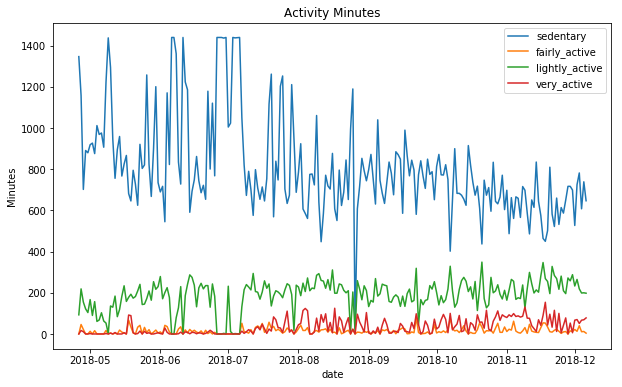

In [18]:
plt.figure(figsize=(10,6))
sns.lineplot(x=fitbit.date, y=fitbit.minutes_sedentary, label='sedentary')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_fairly_active, label='fairly_active')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_lightly_active, label='lightly_active')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_very_active, label='very_active')
plt.ylabel('Minutes')
plt.title('Activity Minutes')
plt.show()

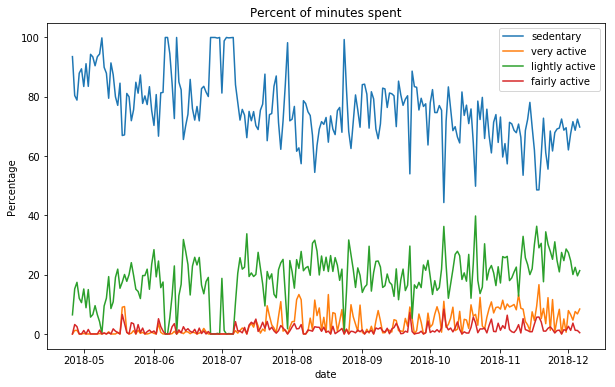

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_sedentary/fitbit.total_minutes*100), label='sedentary')
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_very_active/fitbit.total_minutes*100), label='very active')
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_lightly_active/fitbit.total_minutes*100), label='lightly active')
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_fairly_active/fitbit.total_minutes*100), label='fairly active')
plt.title('Percent of minutes spent')
plt.ylabel('Percentage')
plt.show()

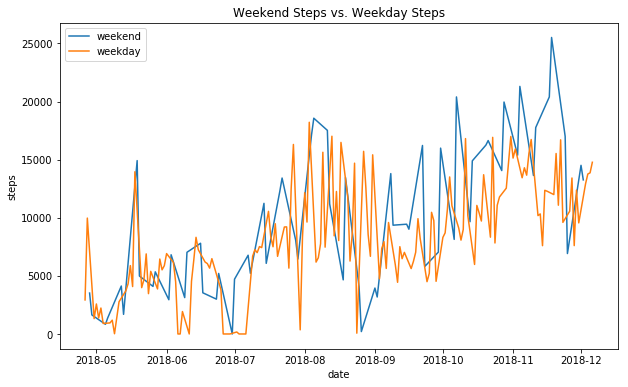

In [20]:
weekend = fitbit.loc[fitbit.weekend_or_weekday == 'weekend']
weekday = fitbit.loc[fitbit.weekend_or_weekday == 'weekday']

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekend, x=weekend.date, y=weekend.steps, label='weekend')
sns.lineplot(data=weekday, x=weekday.date, y=weekday.steps, label='weekday')
plt.title('Weekend Steps vs. Weekday Steps')
plt.show()

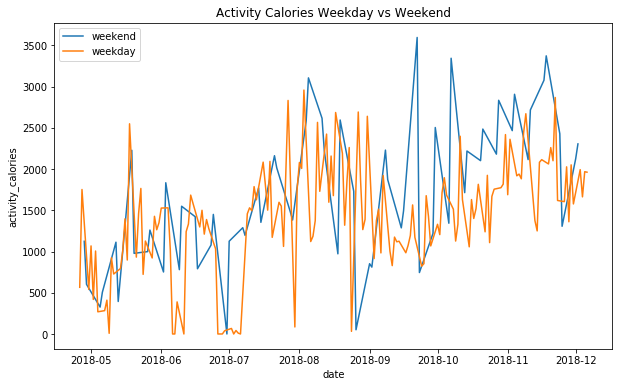

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekend, x=weekend.date, y=weekend.activity_calories, label='weekend')
sns.lineplot(data=weekday, x=weekday.date, y=weekday.activity_calories, label='weekday')
plt.title('Activity Calories Weekday vs Weekend')
plt.show()

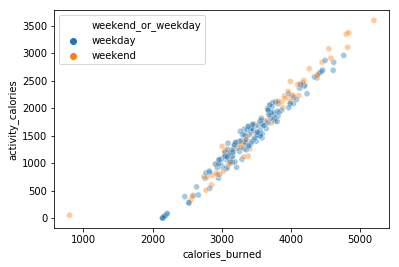

In [22]:
sns.scatterplot(x=fitbit.calories_burned, y=fitbit.activity_calories, hue=fitbit.weekend_or_weekday, alpha=.4)

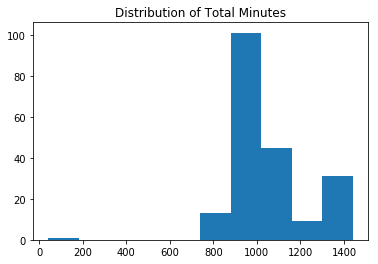

In [23]:
plt.hist(fitbit.total_minutes.iloc[:200])
plt.title('Distribution of Total Minutes')
plt.show()

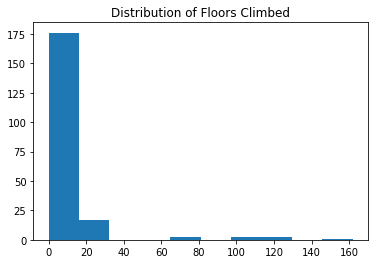

In [24]:
plt.hist(fitbit.floors.iloc[:200])
plt.title('Distribution of Floors Climbed')
plt.show()

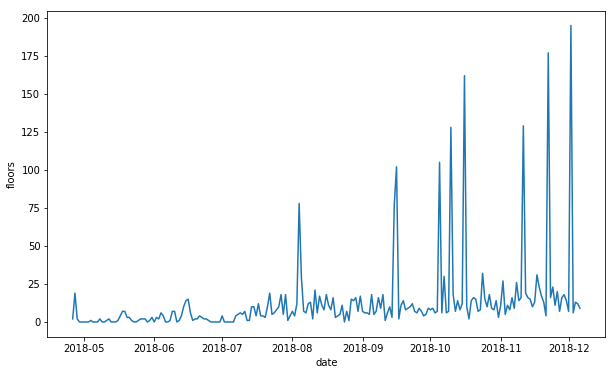

In [25]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=fitbit.date, y=fitbit.floors)

In [26]:
fitbit.set_index('date', inplace=True, drop=True)

##### Sampling based on amount of days. (Steps)
We want the test data set to be at least 30 days so that any monthly trends can be tested.

In [27]:
train = fitbit.steps[:194]
test = fitbit.steps[194:225]
data_to_predict = fitbit.steps[225:]

In [28]:
print(train.shape)
print(test.shape)

(194,)
(31,)


In [29]:
train.describe()

count      194.000000
mean      7757.231959
std       5034.975689
min          0.000000
25%       4346.250000
50%       7025.000000
75%      10684.500000
max      21302.000000
Name: steps, dtype: float64

In [30]:
# q1 = 4346.25
# q3 = 10684.5
# iqr = q3 - q1
# crit = iqr * 1.5
# upper = q3 + crit
# lower = q1 - crit

# train = train[(train > lower) & (train < upper)]


In [31]:
# print(upper)
# print(lower)

In [32]:
# train.describe()

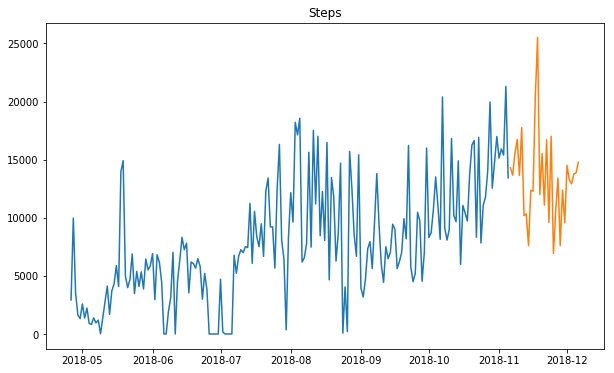

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train)
plt.plot(test)
plt.title('Steps')
plt.show()

In [34]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat.head()

actual  avg_forecast
date                             
2018-11-06  14300.0   7757.231959
2018-11-07  13664.0   7757.231959
2018-11-08  15542.0   7757.231959
2018-11-09  16732.0   7757.231959
2018-11-10  13636.0   7757.231959

In [35]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

### Simple Average

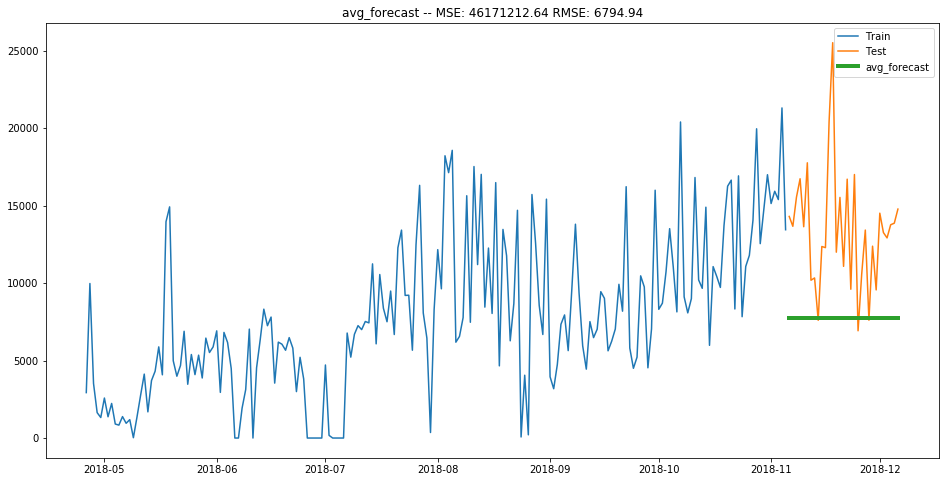

In [36]:
plot_and_eval(yhat.avg_forecast)

### Rolling Average

##### Past 30 days

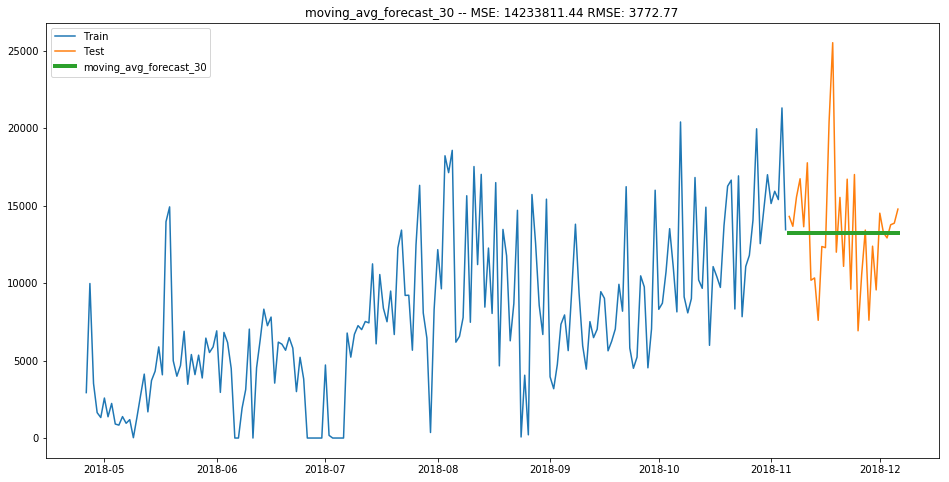

In [37]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]
plot_and_eval(yhat.moving_avg_forecast_30)

##### Past 1 day, 1 week, 2 weeks, 3 weeks, 2 months, and 3 months

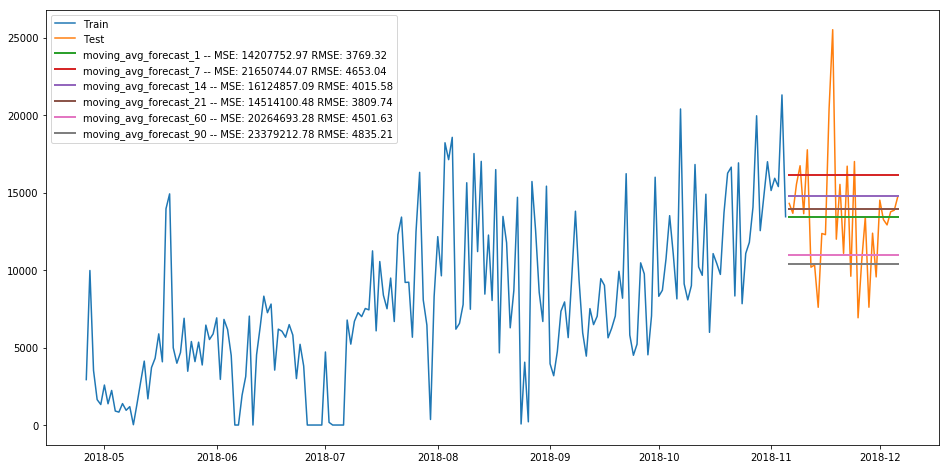

In [38]:
period_vals = [1, 7, 14, 21, 60, 90]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

### Holt Linear Trend

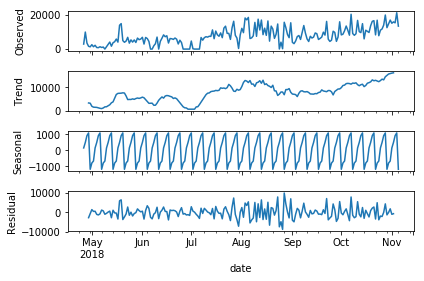

In [39]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [40]:
holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

yhat['holt_linear'] = holt.forecast(test.shape[0])

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


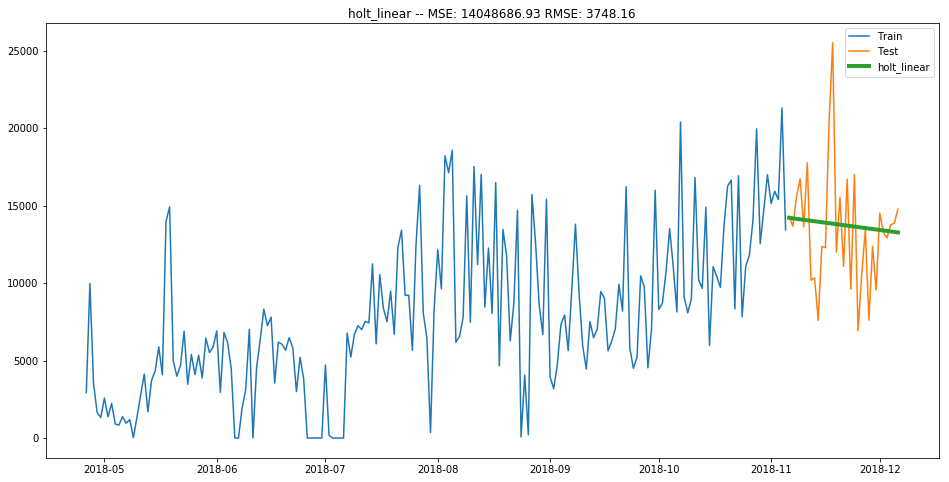

In [41]:
plot_and_eval(yhat.holt_linear)

### Predicting based off last N days
31 days in this case

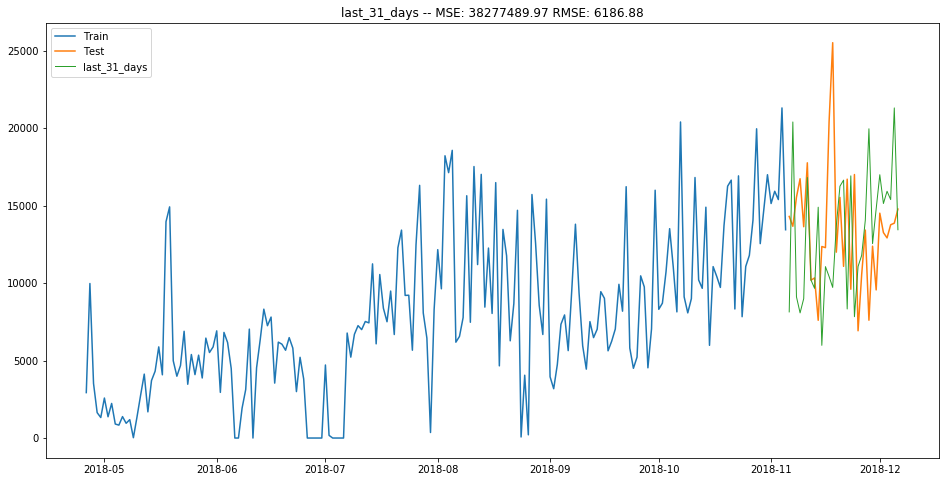

In [42]:
using_last_year = train[163:194].reset_index().drop(columns='date').set_index(test.index)

yhat['last_31_days'] = using_last_year
plot_and_eval(yhat.last_31_days, linewidth=1)

### Prophet model

In [43]:
prophet_df = pd.DataFrame(dict(ds=fitbit.reset_index().date[:194]))
prophet_df['y'] = fitbit.reset_index().steps[:194]

In [44]:
# prophet_df.dropna(inplace=True)

In [45]:
prophet_df.tail()

ds        y
189 2018-11-01  15134.0
190 2018-11-02  15924.0
191 2018-11-03  15388.0
192 2018-11-04  21302.0
193 2018-11-05  13441.0

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


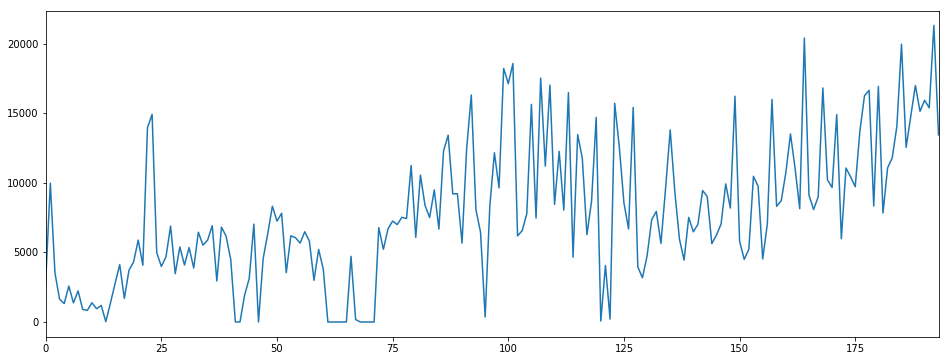

In [46]:
plt.figure(figsize=(16,6))
sns.tsplot(prophet_df.y)

In [47]:
prophet_df['cap'] = 22000
prophet_df['floor'] = 0

m = Prophet(growth='logistic', changepoint_range=0.8)
m.fit(prophet_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 26000
future['floor'] = 0
print(future.head())
print(future.tail())
print(prophet_df.tail())

          ds    cap  floor
0 2018-04-26  26000      0
1 2018-04-27  26000      0
2 2018-04-28  26000      0
3 2018-04-29  26000      0
4 2018-04-30  26000      0
            ds    cap  floor
211 2018-11-23  26000      0
212 2018-11-24  26000      0
213 2018-11-25  26000      0
214 2018-11-26  26000      0
215 2018-11-27  26000      0
            ds        y    cap  floor
189 2018-11-01  15134.0  22000      0
190 2018-11-02  15924.0  22000      0
191 2018-11-03  15388.0  22000      0
192 2018-11-04  21302.0  22000      0
193 2018-11-05  13441.0  22000      0


In [49]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
211 2018-11-23  18065.135649  13256.496008  22847.737397
212 2018-11-24  18262.307936  13113.133332  23332.581708
213 2018-11-25  18757.377934  14009.561042  23458.832722
214 2018-11-26  16362.935064  11191.389632  21670.506135
215 2018-11-27  16753.228849  11547.089408  21821.490531

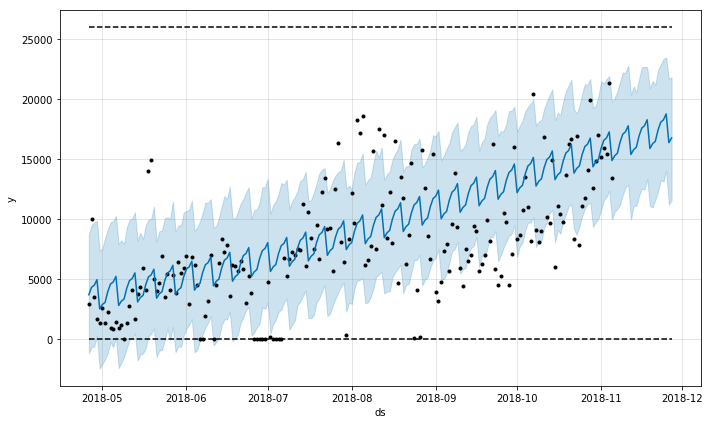

In [50]:
fig1 = m.plot(forecast)

In [51]:
columns = fitbit.columns[1:9]

### Performing TSA for other variables.

Performing TSA for steps.


Train/Test plot


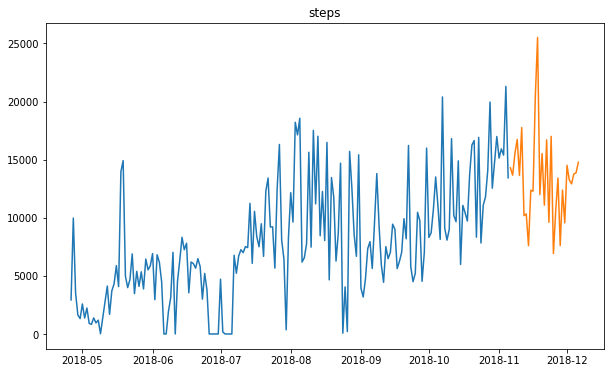



Simple Average


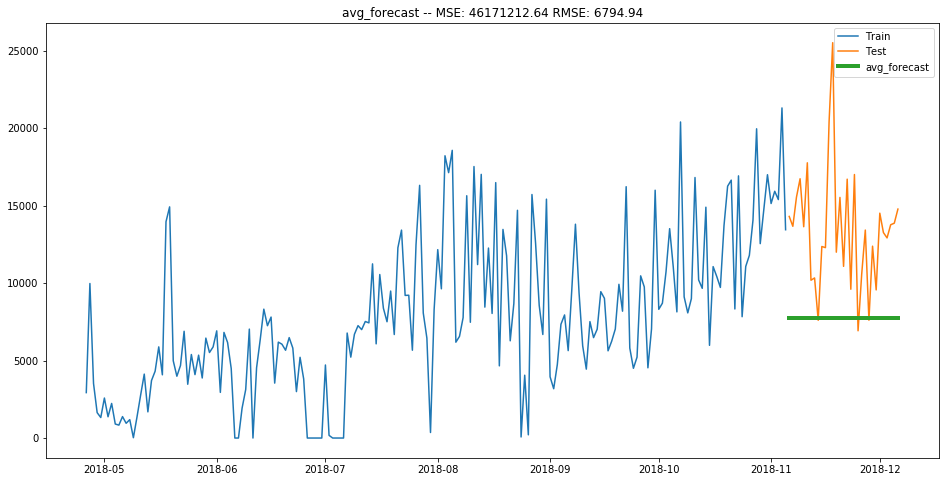



Rolling Average


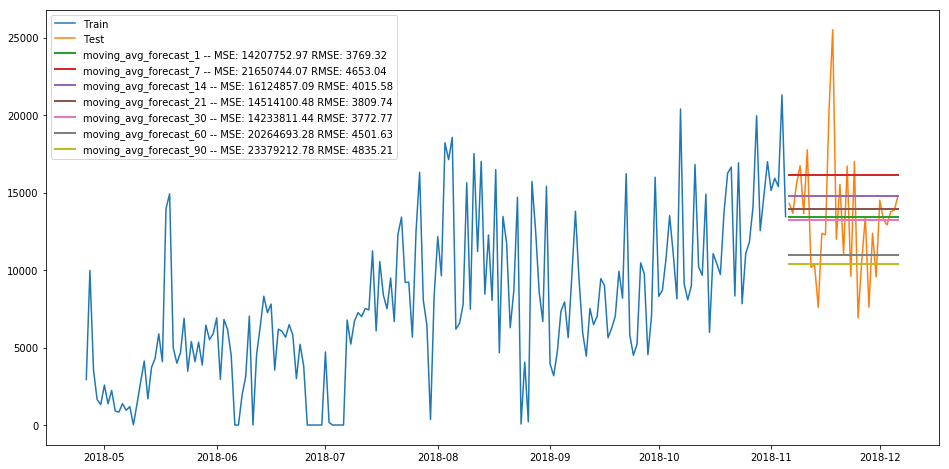



Holt Linear Trend


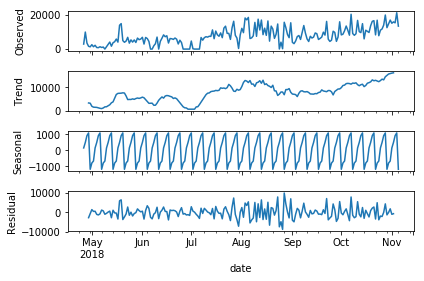

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


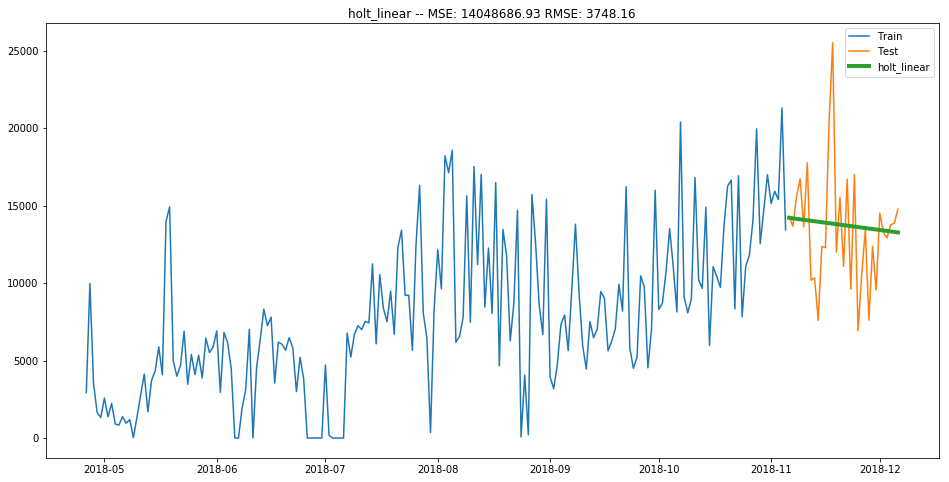



Predicting based off last 31 days


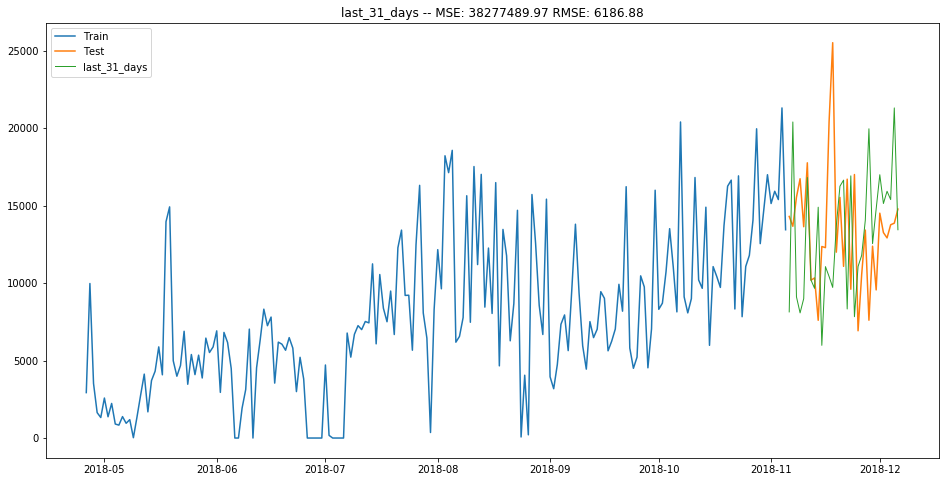

Performing TSA for distance.


Train/Test plot


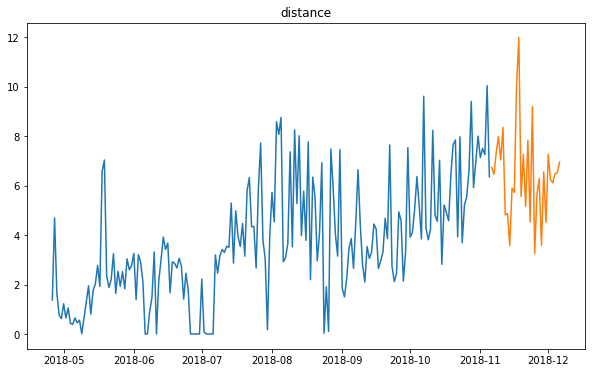



Simple Average


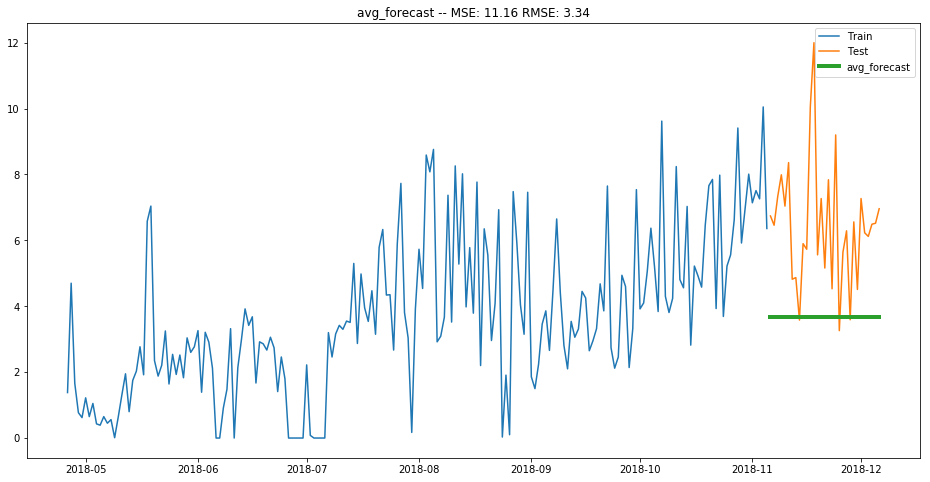



Rolling Average


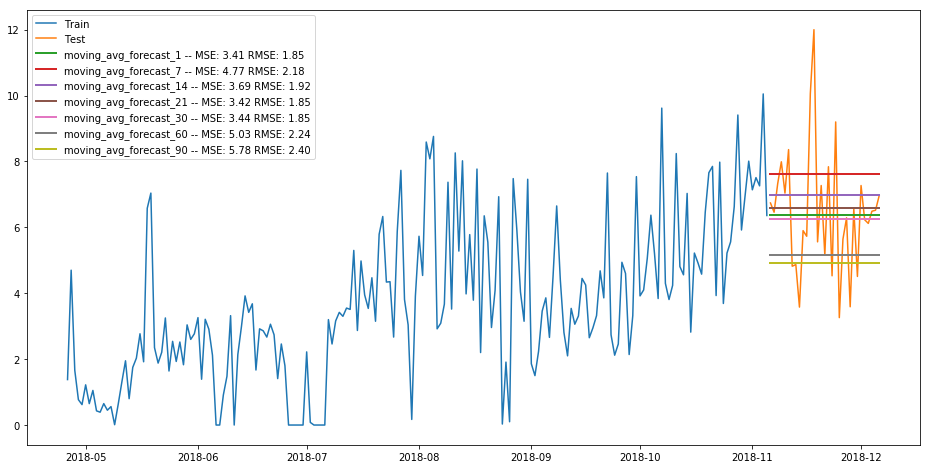



Holt Linear Trend


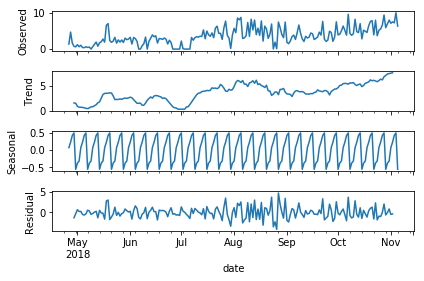

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


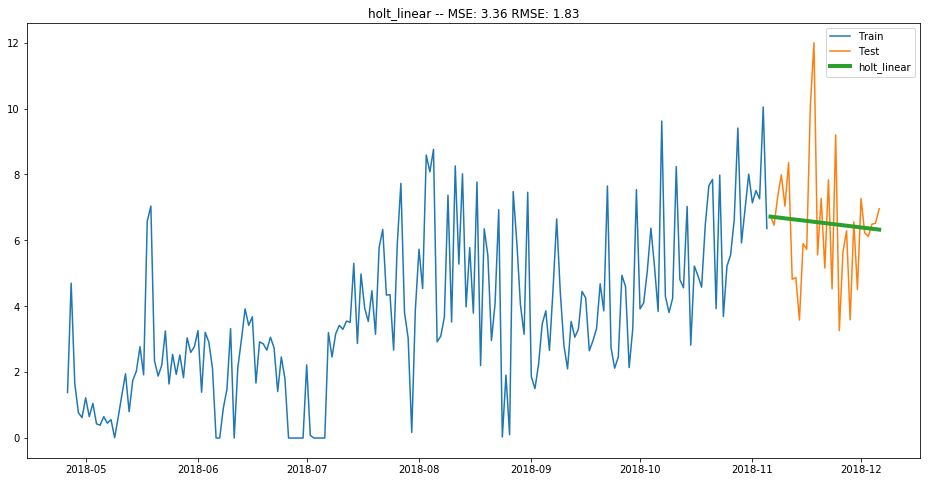



Predicting based off last 31 days


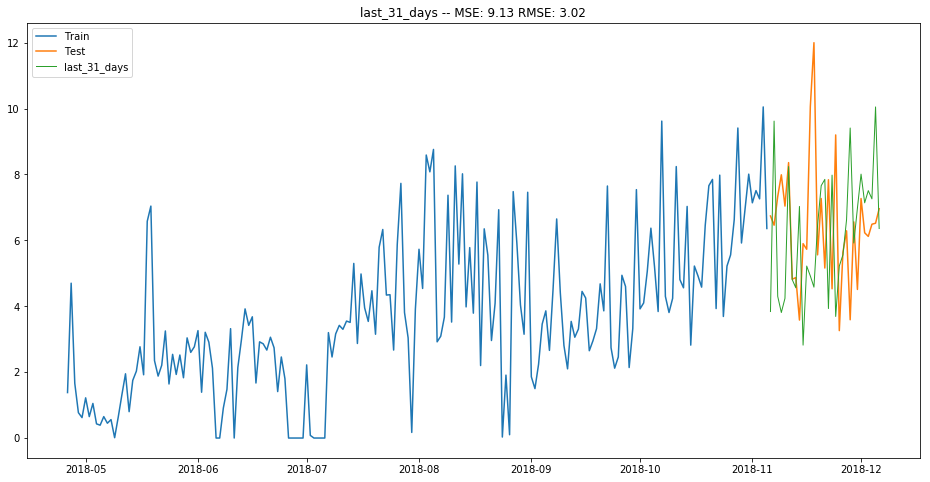

Performing TSA for floors.


Train/Test plot


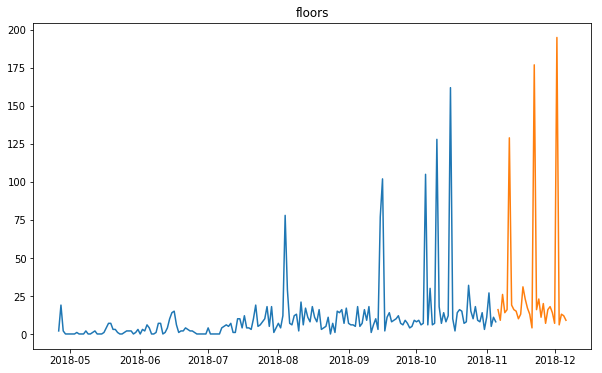



Simple Average


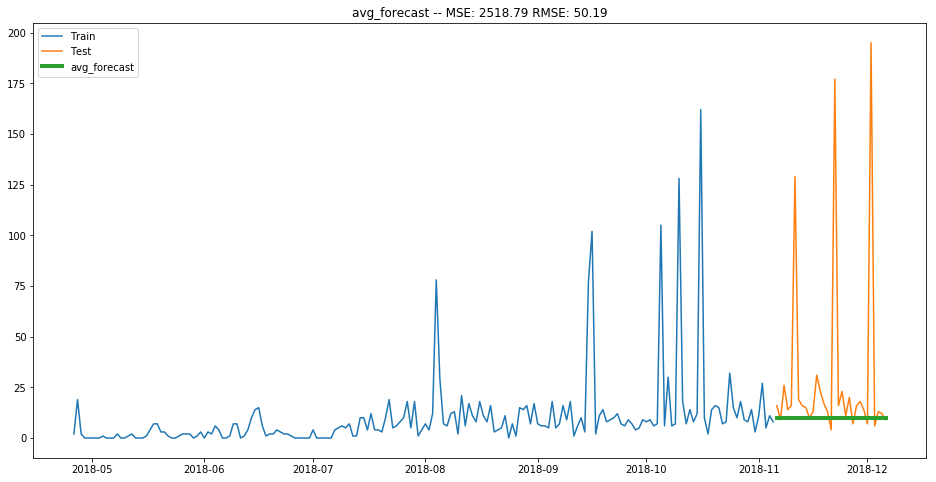



Rolling Average


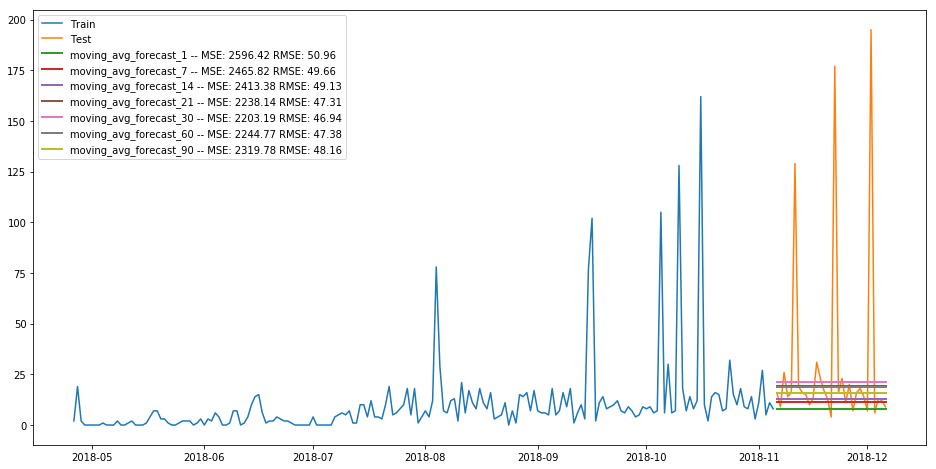



Holt Linear Trend


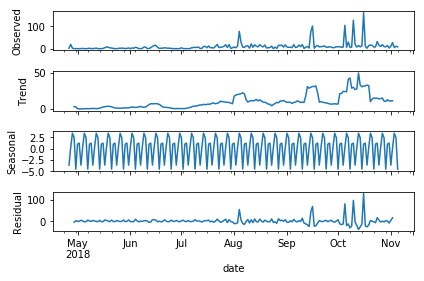

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


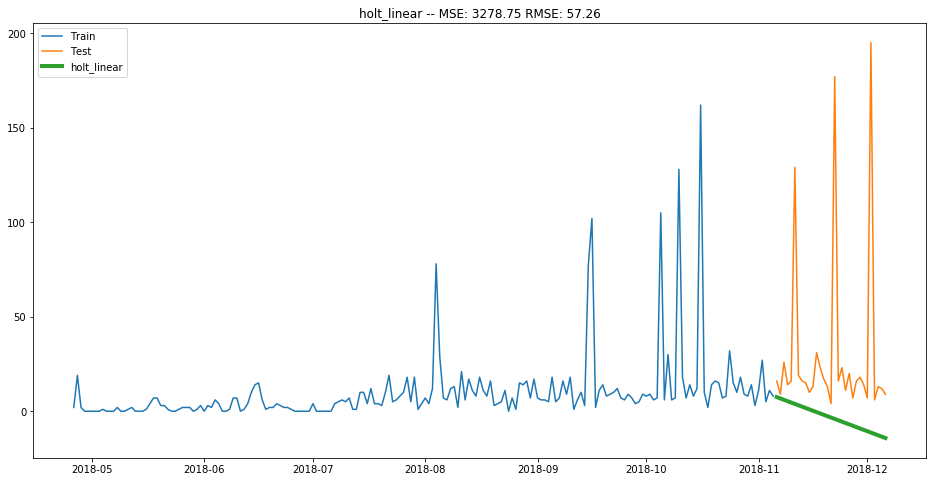



Predicting based off last 31 days


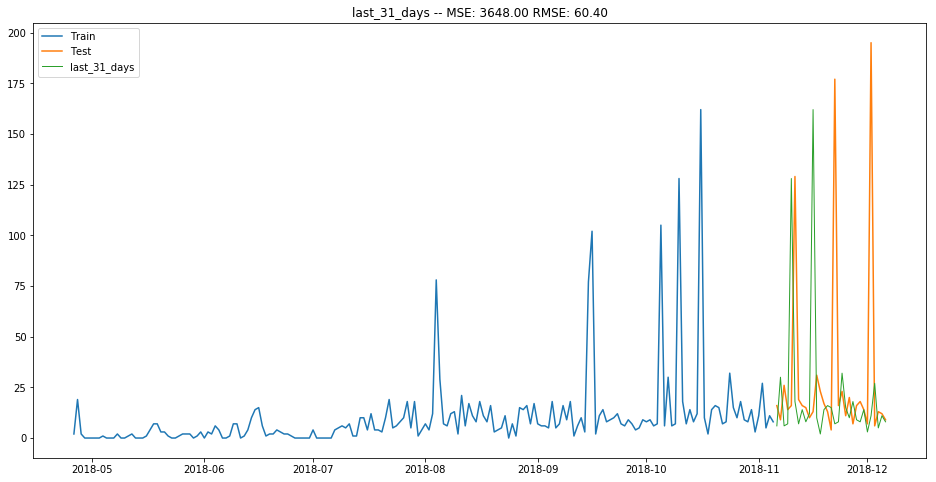

Performing TSA for minutes_sedentary.


Train/Test plot


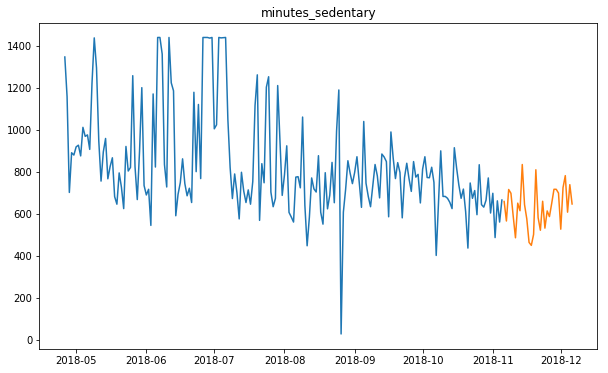



Simple Average


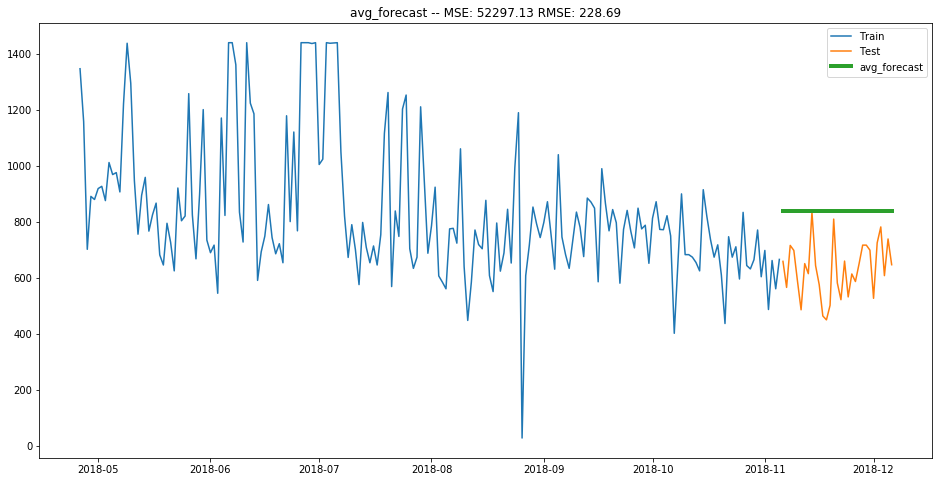



Rolling Average


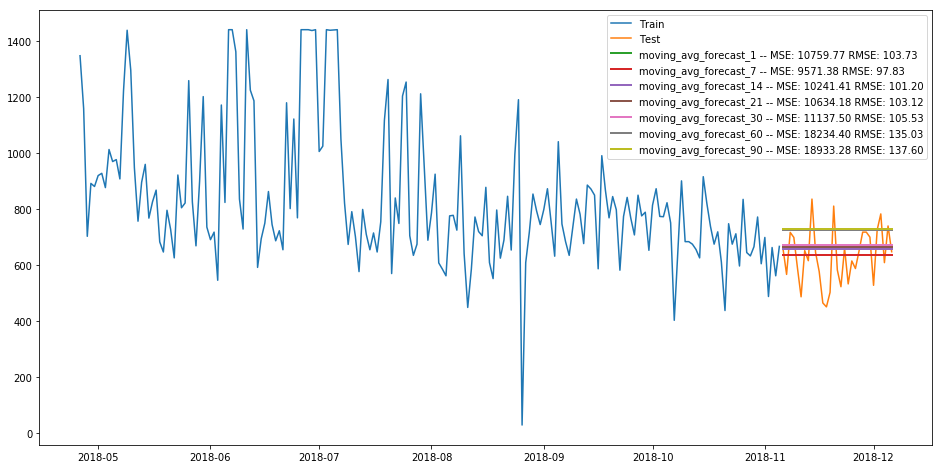



Holt Linear Trend


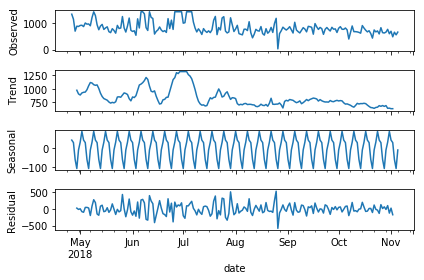

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


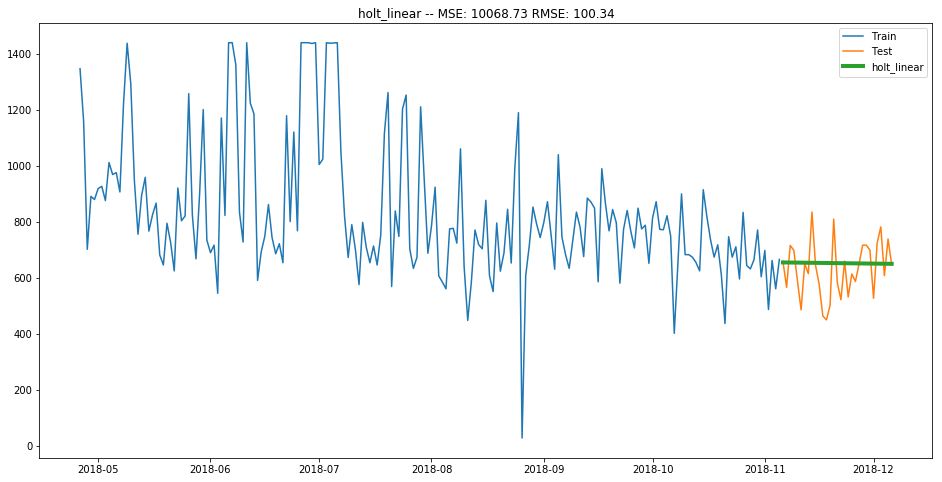



Predicting based off last 31 days


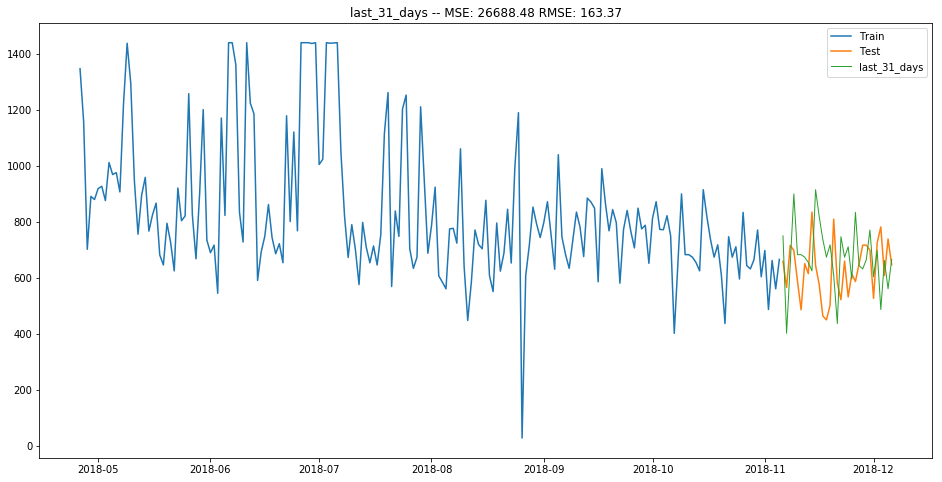

Performing TSA for minutes_lightly_active.


Train/Test plot


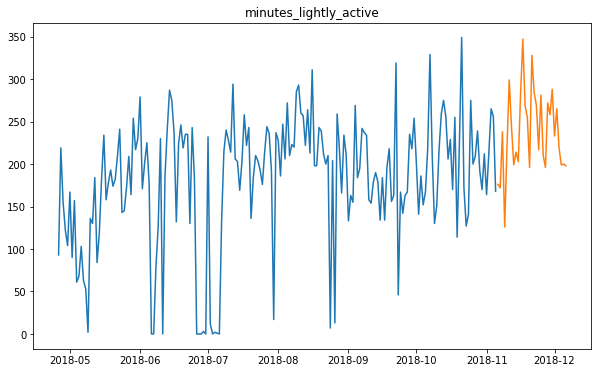



Simple Average


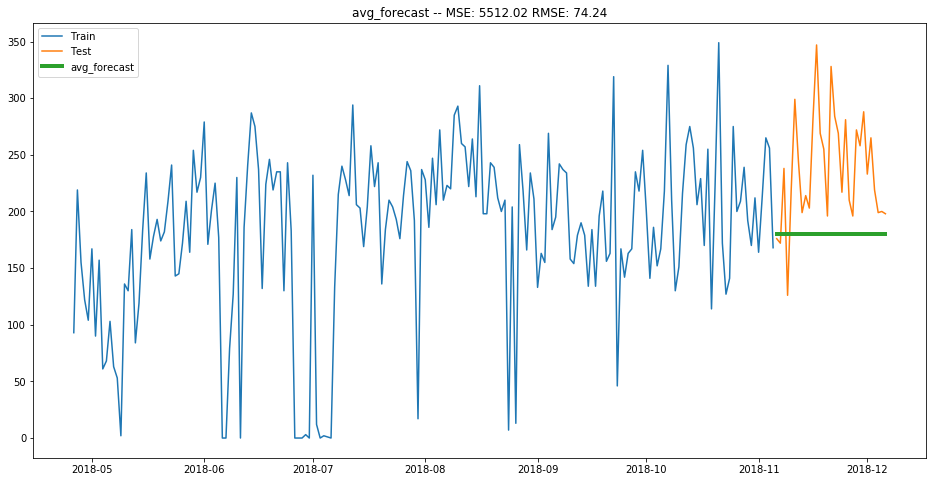



Rolling Average


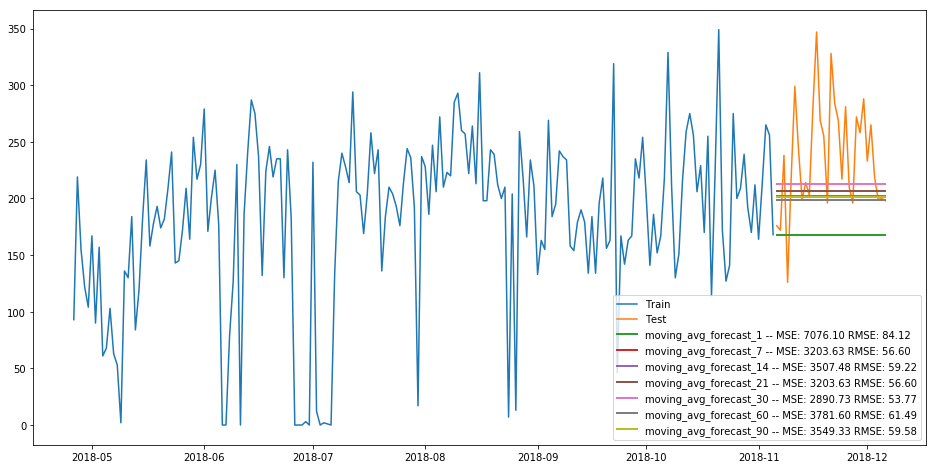



Holt Linear Trend


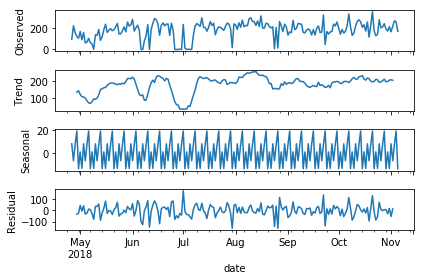

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


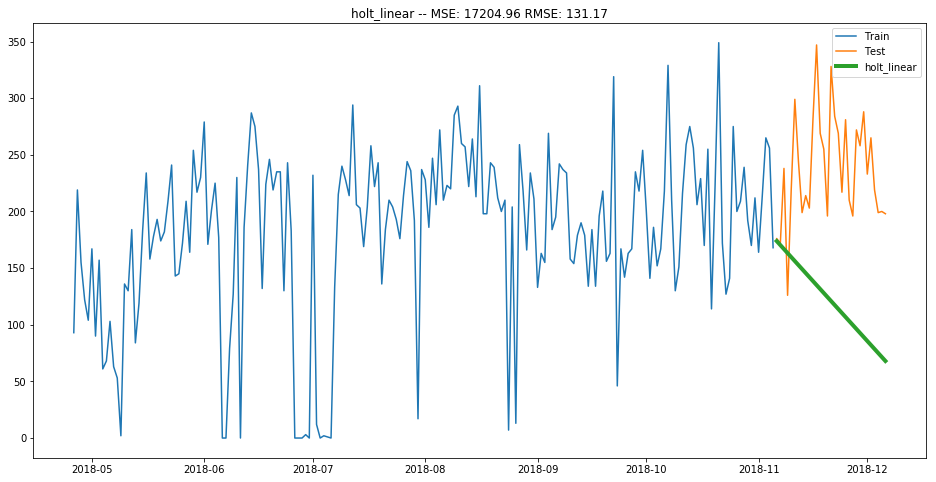



Predicting based off last 31 days


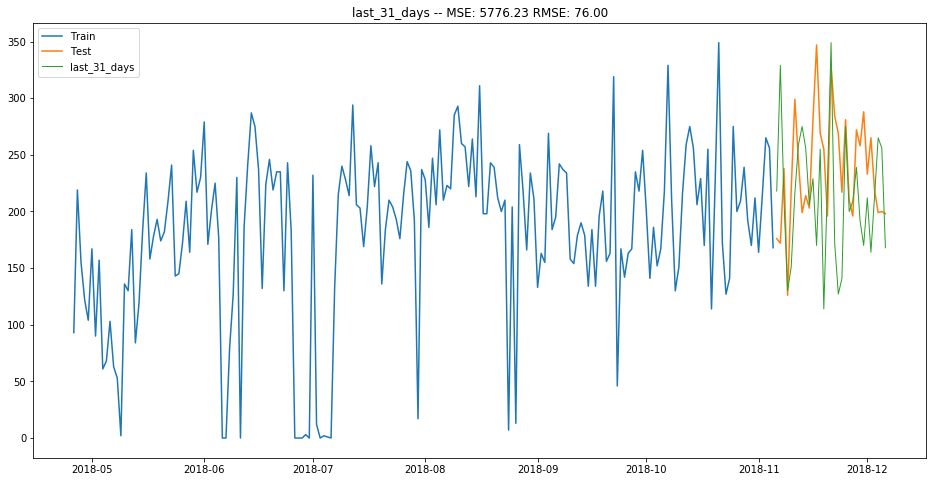

Performing TSA for minutes_fairly_active.


Train/Test plot


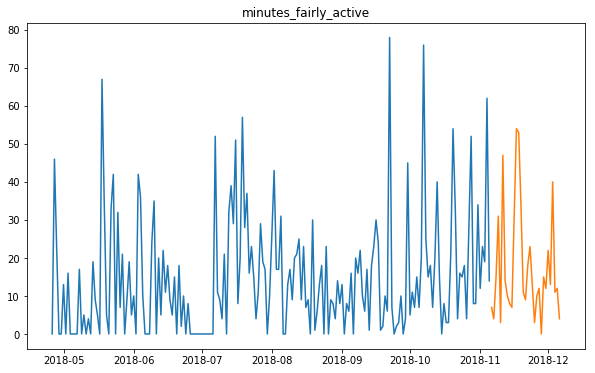



Simple Average


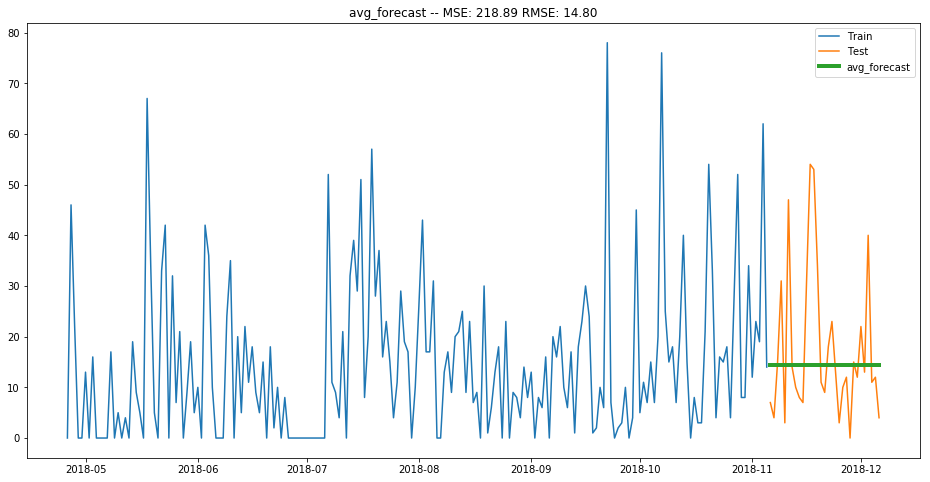



Rolling Average


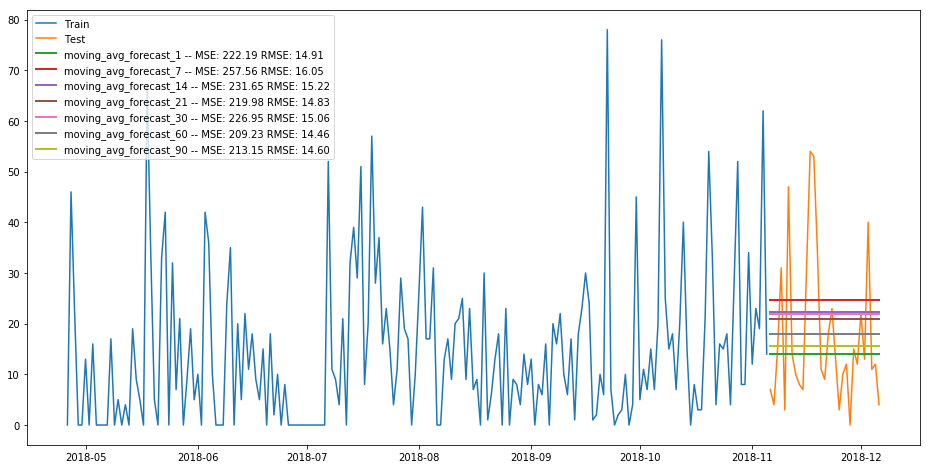



Holt Linear Trend


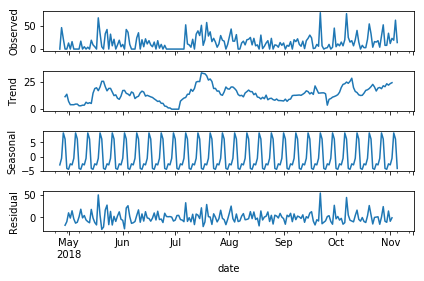

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


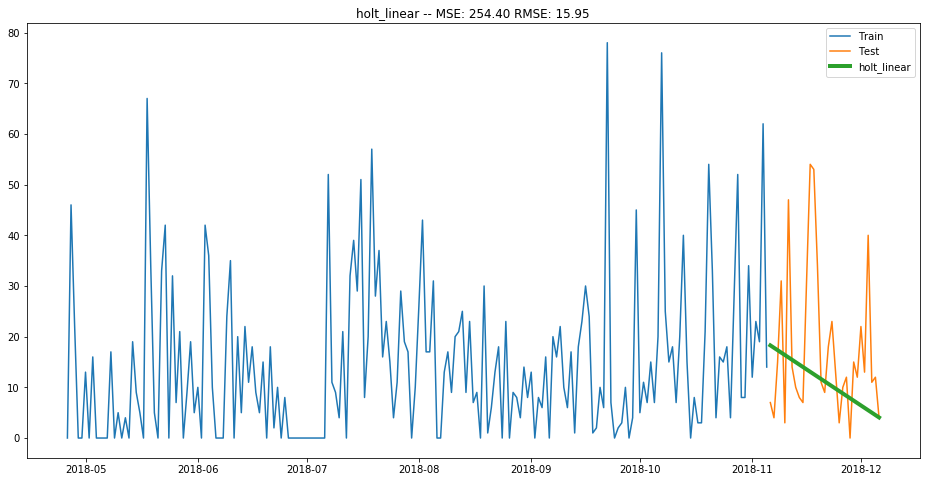



Predicting based off last 31 days


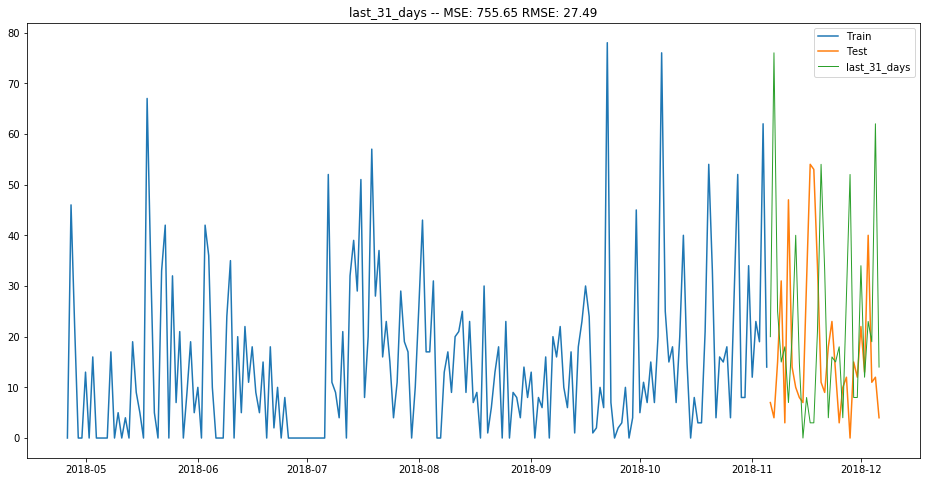

Performing TSA for minutes_very_active.


Train/Test plot


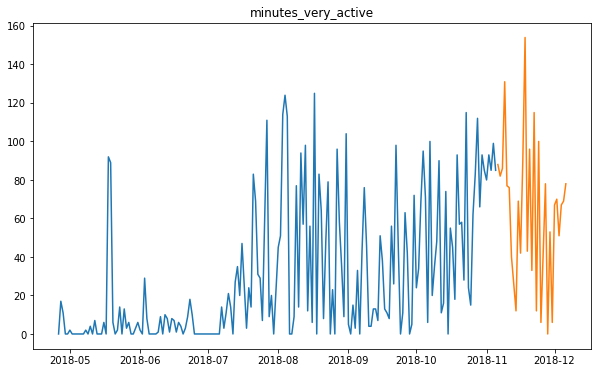



Simple Average


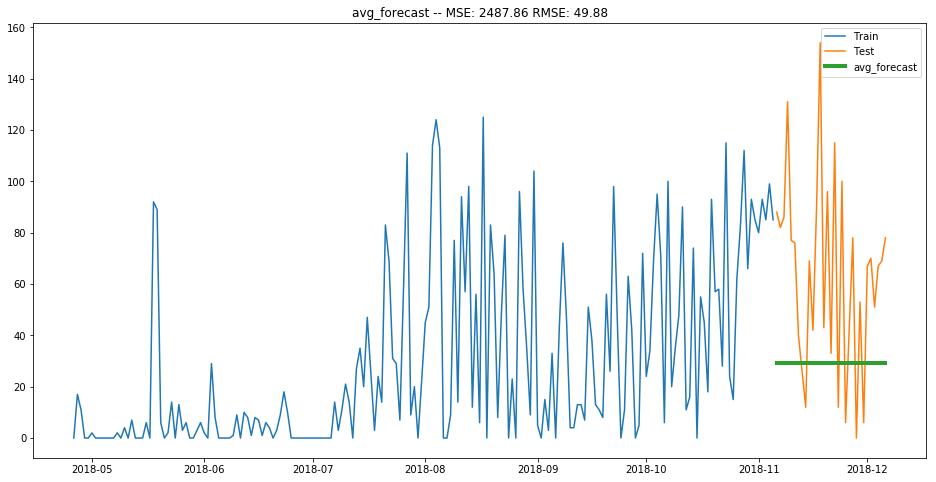



Rolling Average


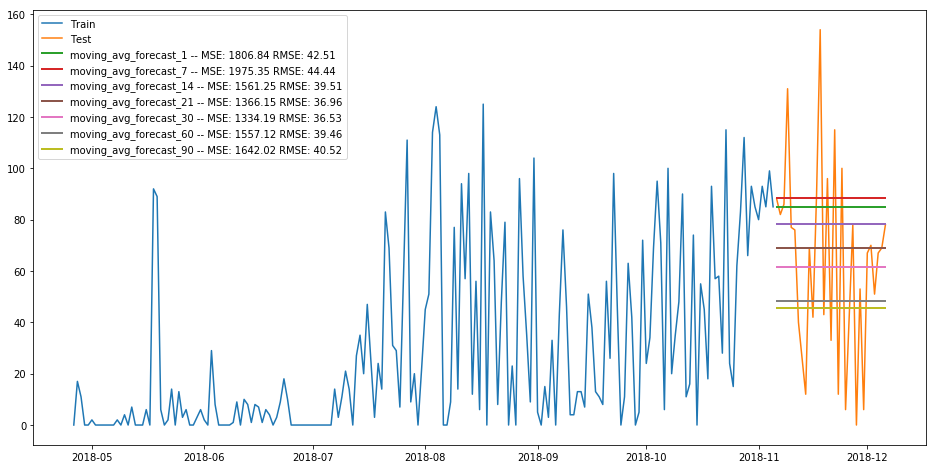



Holt Linear Trend


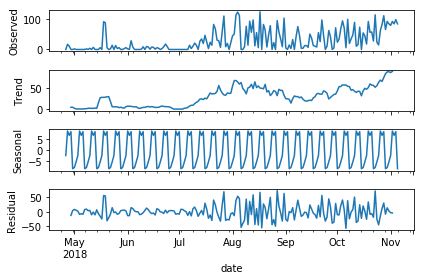

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


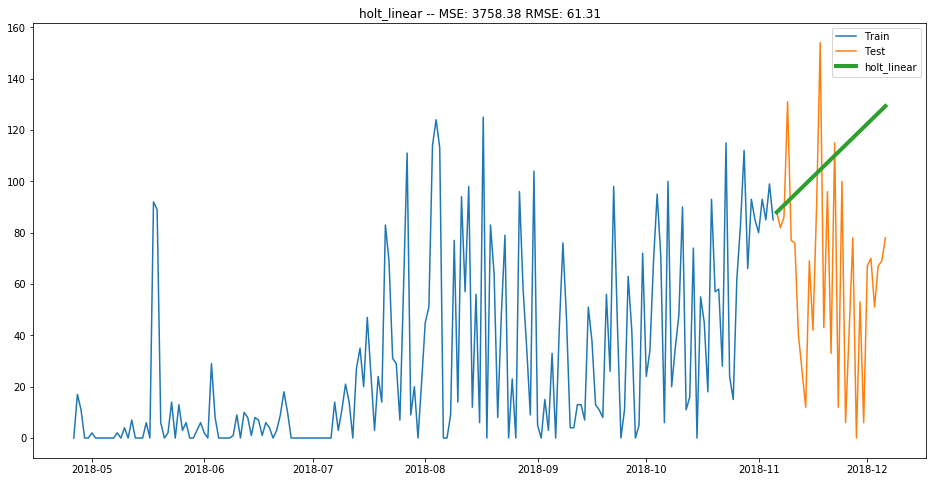



Predicting based off last 31 days


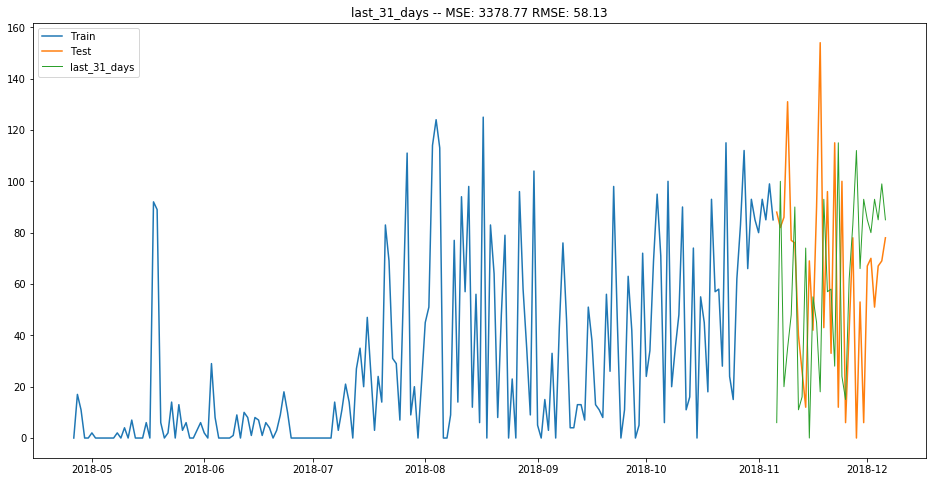

Performing TSA for activity_calories.


Train/Test plot


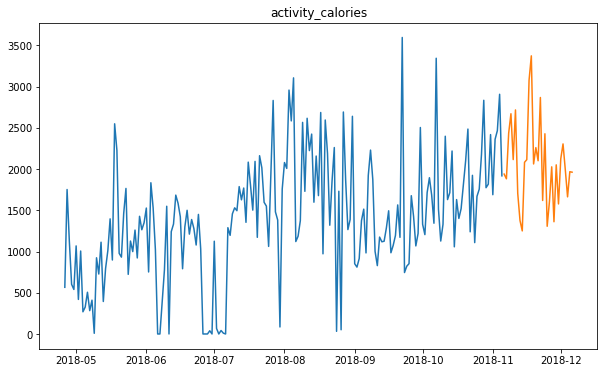



Simple Average


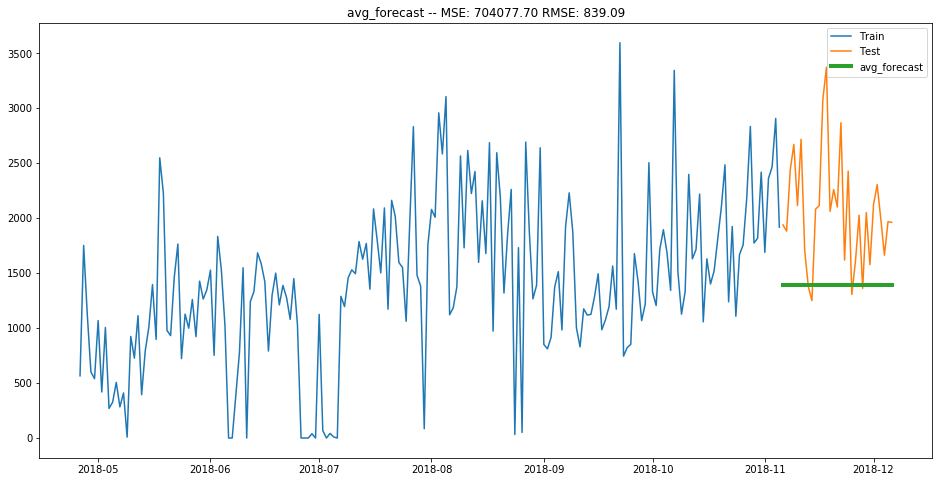



Rolling Average


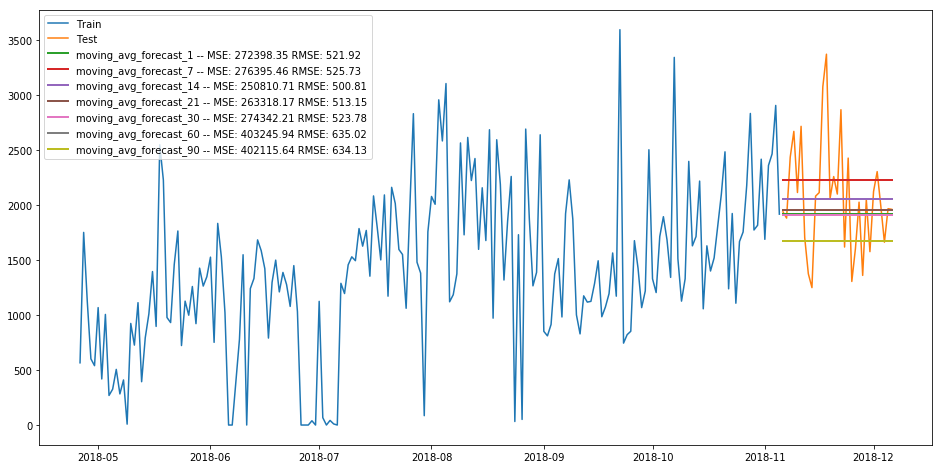



Holt Linear Trend


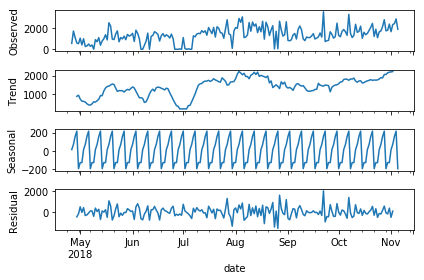

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


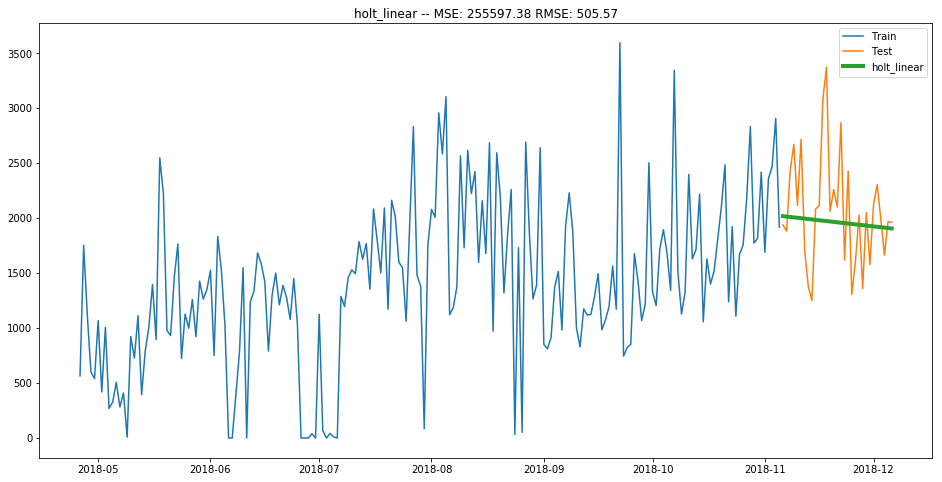



Predicting based off last 31 days


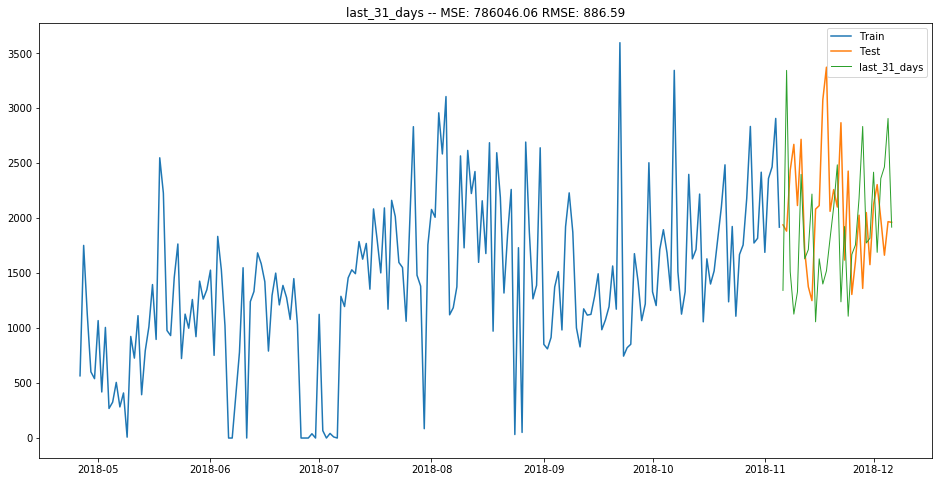

In [52]:
for col in columns:
    print(f'Performing TSA for {col}.')
    train = fitbit[col][:194]
    test = fitbit[col][194:225]
    data_to_predict = fitbit[col][225:]

    print('\n')
    print(f'Train/Test plot')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train)
    plt.plot(test)
    plt.title(col)
    plt.show()
    
    yhat = pd.DataFrame(dict(actual=test))
    yhat['avg_forecast'] = train.mean()
    yhat.head()
    
    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
            mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
            if len(predictions) > 1:
                label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

        if len(predictions) == 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()    
    
    print('\n')
    print(f'Simple Average')
    plot_and_eval(yhat.avg_forecast)
    
    print('\n')
    print(f'Rolling Average')
    
    period_vals = [1, 7, 14, 21, 30, 60, 90]

    for periods in period_vals:
        yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

    forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

    plot_and_eval(forecasts, linewidth=2)
    
    print('\n')
    print(f'Holt Linear Trend')
    
    sm.tsa.seasonal_decompose(train).plot()
    result = sm.tsa.stattools.adfuller(train)
    plt.show()
    
    holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

    yhat['holt_linear'] = holt.forecast(test.shape[0])
    
    plot_and_eval(yhat.holt_linear)
    
    print('\n')
    print(f'Predicting based off last 31 days')
    
    using_last_year = train[163:194].reset_index().drop(columns='date').set_index(test.index)

    yhat['last_31_days'] = using_last_year
    plot_and_eval(yhat.last_31_days, linewidth=1)

In [53]:
columns

Index(['steps', 'distance', 'floors', 'minutes_sedentary',
       'minutes_lightly_active', 'minutes_fairly_active',
       'minutes_very_active', 'activity_calories'],
      dtype='object')

### Holt Linear Trend for different variables

In [54]:
def holt_linear(col, smoothing_level, smoothing_slope):
    print(col)
    train = fitbit[col][:194]
    test = fitbit[col][194:225]

    yhat = pd.DataFrame(dict(actual=test))
    yhat['avg_forecast'] = train.mean()
    yhat.head()

    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
            mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
            if len(predictions) > 1:
                label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

        if len(predictions) == 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()    

    print(f'Holt Linear Trend')

    sm.tsa.seasonal_decompose(train).plot()
    result = sm.tsa.stattools.adfuller(train)
    plt.show()

    holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    yhat['holt_linear'] = holt.forecast(test.shape[0])

    plot_and_eval(yhat.holt_linear)

steps
Holt Linear Trend


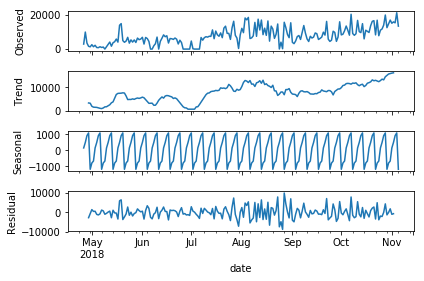

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


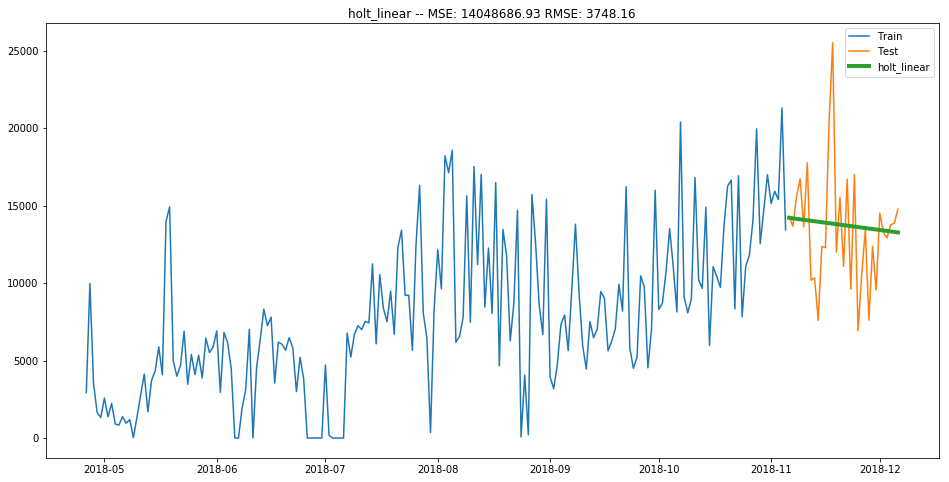

In [55]:
holt_linear('steps', .9, .1)

distance
Holt Linear Trend


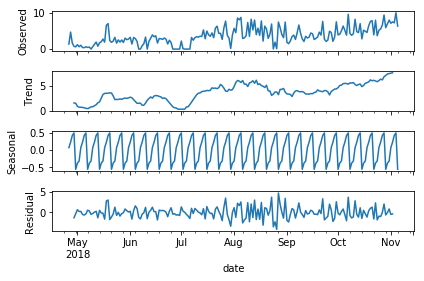

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


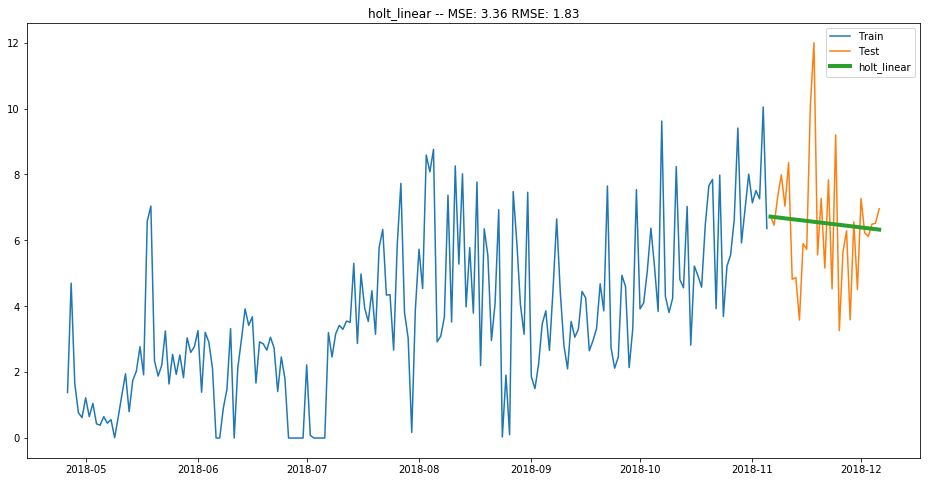

In [56]:
holt_linear('distance', .9, .1)

floors
Holt Linear Trend


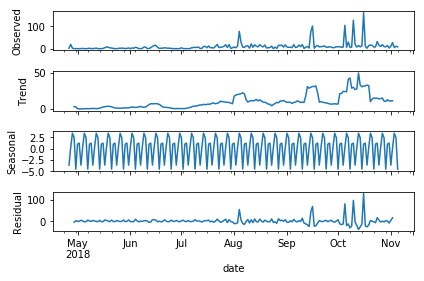

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


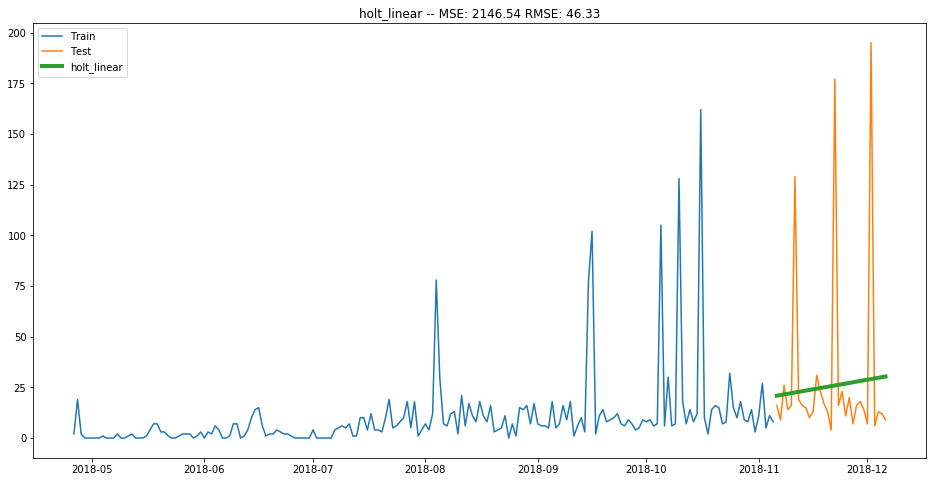

In [57]:
holt_linear('floors', .095, .905)

minutes_sedentary
Holt Linear Trend


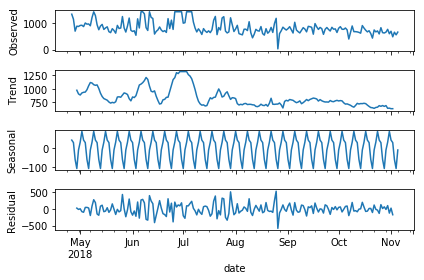

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


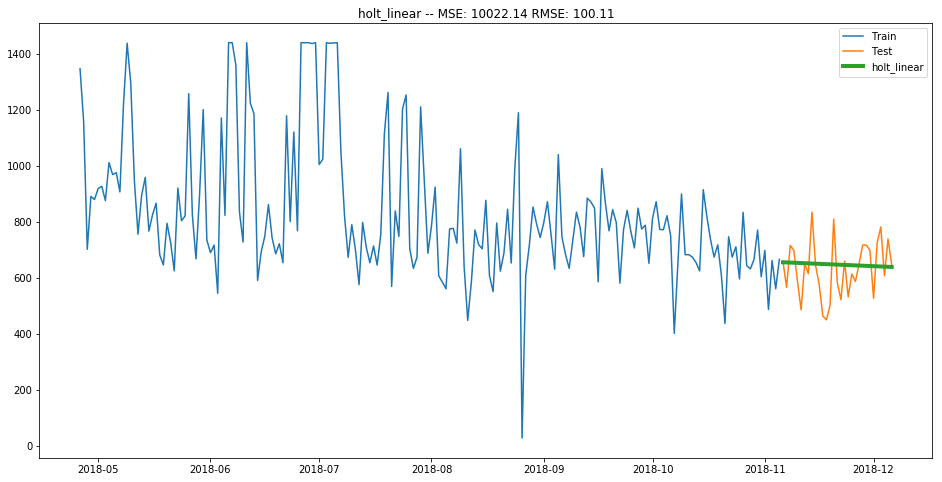

In [58]:
holt_linear('minutes_sedentary', .90005, .00095)

minutes_lightly_active
Holt Linear Trend


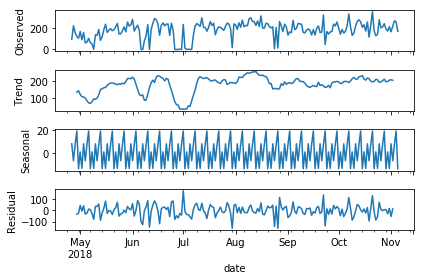

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


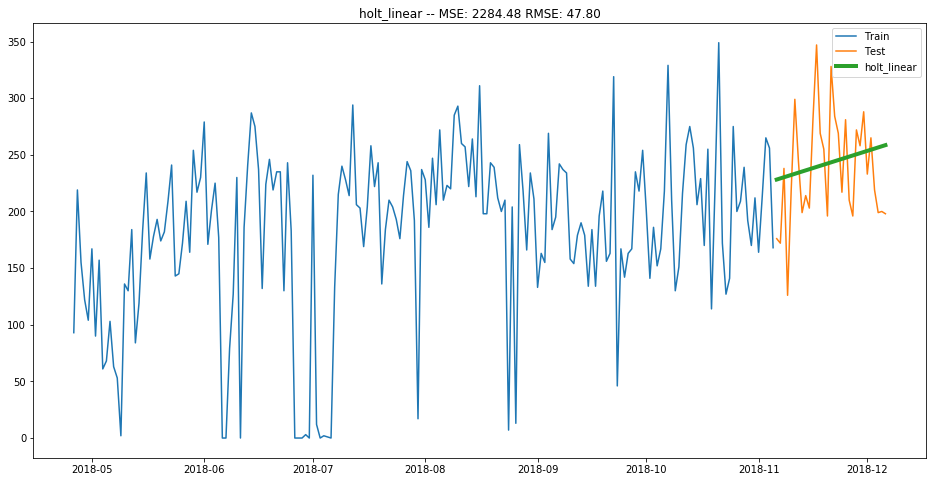

In [59]:
holt_linear('minutes_lightly_active', .35, .65)

minutes_fairly_active
Holt Linear Trend


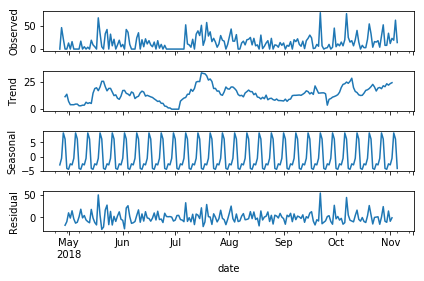

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


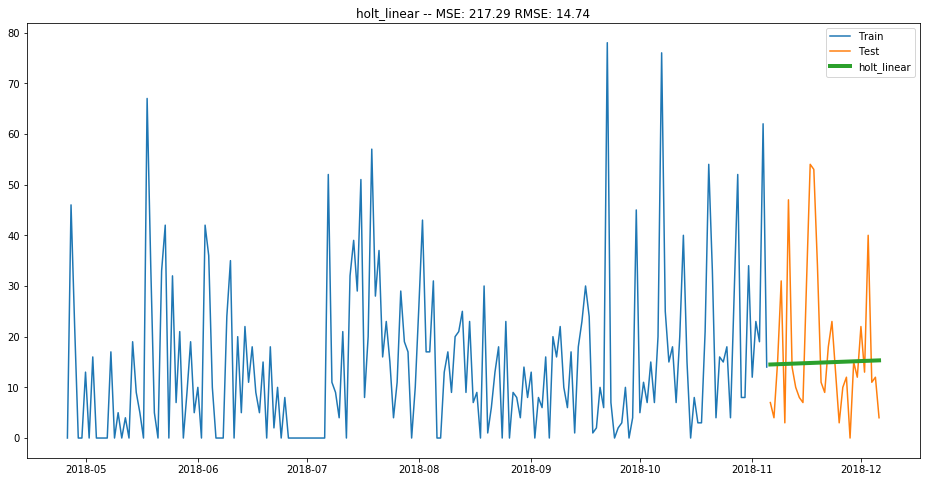

In [60]:
holt_linear('minutes_fairly_active', .99, .01)

minutes_very_active
Holt Linear Trend


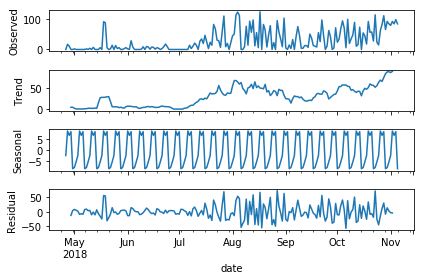

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


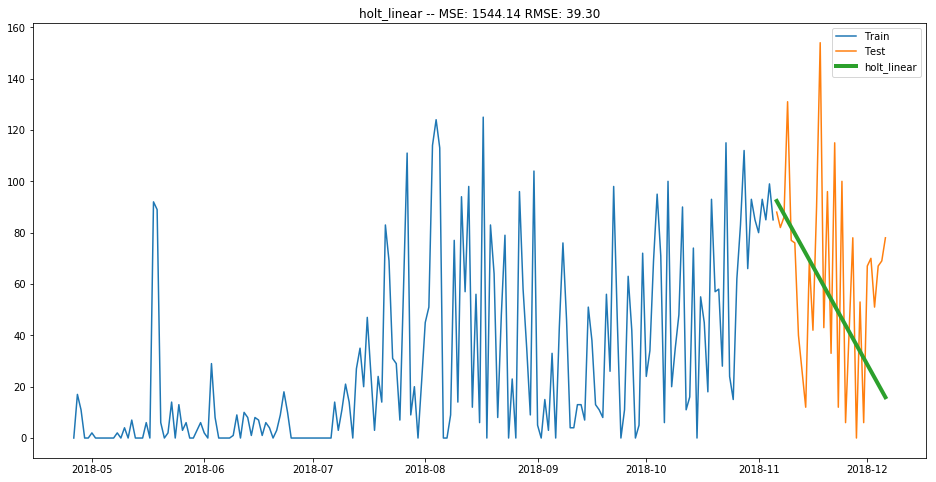

In [61]:
holt_linear('minutes_very_active', .25, .75)
#36.53

activity_calories
Holt Linear Trend


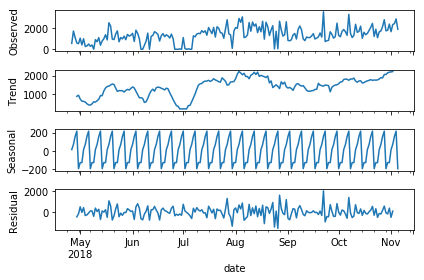

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


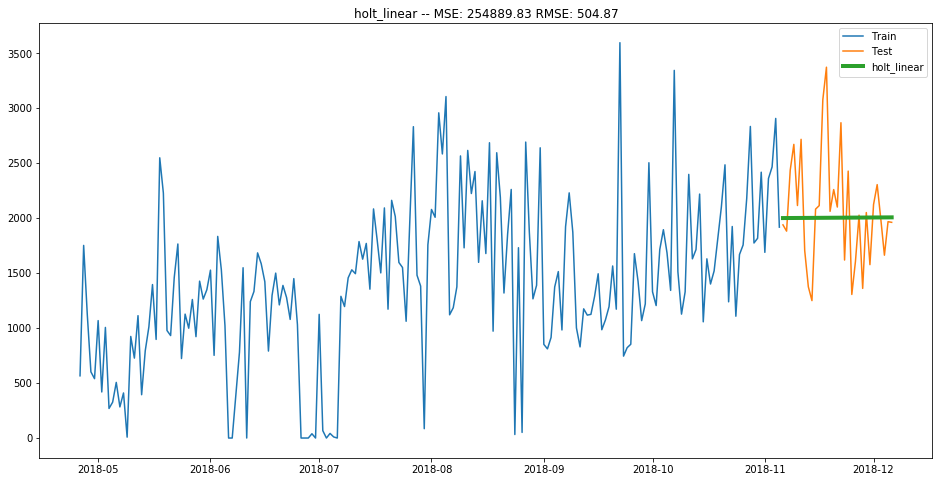

In [62]:
holt_linear('activity_calories', .92, .08)

In [63]:
fitbit[fitbit.floors > 50]

calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-08-04           4376.0  17126.0      8.08    78.0              585.0   
2018-09-15           3180.0   9445.0      4.45    77.0              849.0   
2018-09-16           3344.0   9015.0      4.25   102.0              586.0   
2018-10-05           3603.0  11029.0      5.20   105.0              822.0   
2018-10-10           3183.0   8996.0      4.24   128.0              683.0   
2018-10-16           3432.0  11061.0      5.22   162.0              819.0   
2018-11-11           4264.0  17761.0      8.36   129.0              486.0   
2018-11-22           4494.0  16705.0      7.84   177.0              522.0   
2018-12-02           3957.0  13257.0      6.23   195.0              725.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-08-04                   206.0                   17.0   
2018-09-15                   134.0                   23.0   
2018-09-16                   184.0                   30.0   
2018-10-05                   167.0                    7.0   
2018-10-10                   151.0                   18.0   
2018-10-16                   229.0                    8.0   
2018-11-11                   299.0                   47.0   
2018-11-22                   284.0                   18.0   
2018-12-02                   265.0                   13.0   

            minutes_very_active  activity_calories  calories  fat (g)  \
date                                                                    
2018-08-04                124.0             2584.0       0.0      0.0   
2018-09-15                 51.0             1287.0       0.0      0.0   
2018-09-16                 38.0             1494.0       0.0      0.0   
2018-10-05                 71.0             1684.0       0.0      0.0   
2018-10-10                 48.0             1330.0       0.0      0.0   
2018-10-16                 55.0             1630.0       0.0      0.0   
2018-11-11                 76.0             2717.0       0.0      0.0   
2018-11-22                115.0             2868.0       0.0      0.0   
2018-12-02                 70.0             2305.0       0.0      0.0   

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-08-04        0.0        0.0          0.0          0.0            0.0   
2018-09-15        0.0        0.0          0.0          0.0            0.0   
2018-09-16        0.0        0.0          0.0          0.0            0.0   
2018-10-05        0.0        0.0          0.0          0.0            0.0   
2018-10-10        0.0        0.0          0.0          0.0            0.0   
2018-10-16        0.0        0.0          0.0          0.0            0.0   
2018-11-11        0.0        0.0          0.0          0.0            0.0   
2018-11-22        0.0        0.0          0.0          0.0            0.0   
2018-12-02        0.0        0.0          0.0          0.0            0.0   

            total_minutes day_of_week weekend_or_weekday  
date                                                      
2018-08-04          932.0    Saturday            weekend  
2018-09-15         1057.0    Saturday            weekend  
2018-09-16          838.0      Sunday            weekend  
2018-10-05         1067.0      Friday            weekday  
2018-10-10          900.0   Wednesday            weekday  
2018-10-16         1111.0     Tuesday            weekday  
2018-11-11          908.0      Sunday            weekend  
2018-11-22          939.0    Thursday            weekday  
2018-12-02         1073.0      Sunday            weekend

### Hypothesizing
- person is sedentary most of the day.
    - probably an office worker or participating in an experiement that doesn't require much physical activity.
- activity is increasing over time
    - maybe trying to become more active

### Notes on fitbit calculations
- one floor climbed = 10 feet in elevation change. only counted on the ascent.
    - https://help.fitbit.com/articles/en_US/Help_article/1141



In [64]:
fitbit['bmr'] = fitbit.calories_burned - fitbit.activity_calories
fitbit['hours_awake'] = fitbit.total_minutes/60
fitbit['hours_asleep'] = 24 - fitbit.hours_awake

In [65]:
fitbit[['total_minutes', 'minutes_sedentary', 'hours_awake', 'hours_asleep']].head()

total_minutes  minutes_sedentary  hours_awake  hours_asleep
date                                                                   
2018-04-26         1440.0             1347.0    24.000000      0.000000
2018-04-27         1440.0             1158.0    24.000000      0.000000
2018-04-28          890.0              702.0    14.833333      9.166667
2018-04-29         1013.0              891.0    16.883333      7.116667
2018-04-30          984.0              880.0    16.400000      7.600000

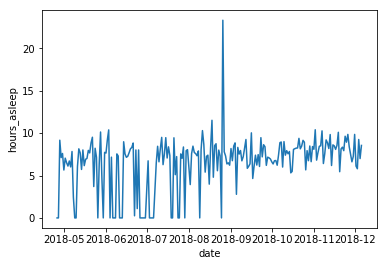

In [66]:
sns.lineplot(x=fitbit.reset_index().date, y=fitbit.reset_index().hours_asleep)

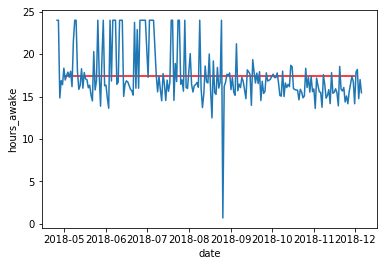

In [67]:
sns.lineplot(x=fitbit.reset_index().date, y=fitbit.reset_index().hours_awake)
plt.hlines(y=fitbit.hours_awake.mean(), xmin='2018-05', xmax='2018-12', colors='r')

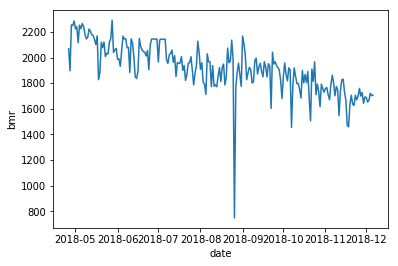

In [68]:
sns.lineplot(x=fitbit.reset_index().date, y=fitbit.reset_index().bmr)

In [69]:
fitbit[fitbit.bmr < 1000]

calories_burned  steps  distance  floors  minutes_sedentary  \
date                                                                      
2018-08-26            799.0  207.0       0.1     1.0               28.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-08-26                    13.0                    0.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-08-26                  0.0               51.0       0.0      ...        

            carbs (g)  sodium (mg)  protein (g)  water (fl oz)  total_minutes  \
date                                                                            
2018-08-26        0.0          0.0          0.0            0.0           41.0   

            day_of_week  weekend_or_weekday    bmr hours_awake  hours_asleep  
date                                                                          
2018-08-26       Sunday             weekend  748.0    0.683333     23.316667  

[1 rows x 22 columns]

### Resampling based on week

In [70]:
# resampled_data = fitbit[:225].resample('W')['steps'].agg('mean')
# train_size = int(len(resampled_data) * 0.6)

# train = resampled_data[:train_size]
# test = resampled_data[train_size:]

In [71]:
# plt.figure(figsize=(10, 6))
# plt.plot(train)
# plt.plot(test)
# plt.title('Steps')
# plt.show()

In [72]:
# using_last_year = resampled_data[5:train_size].reset_index().drop(columns='date').set_index(test.index)

In [73]:
# yhat = pd.DataFrame(dict(actual=test))
# yhat['last_31_days'] = using_last_year

In [74]:
# plot_and_eval(yhat.last_31_days, linewidth=1)

### SVR

In [75]:
# from sklearn import svm
# import numpy as np

In [76]:
# train = np.array(fitbit.steps[:194])
# test = np.array(fitbit.steps[194:225])

In [77]:
# def embed_data(x, steps):
#     n = len(x)
#     xout = np.zeros((n-steps, steps))
#     yout = x[steps:]
#     for i in np.arange(steps, n):
#         xout[i-steps] = x[i-steps:i]
#     return xout, yout

# xtrain,ytrain = embed_data(train, 3)
# xtest,ytest = embed_data(test, 3)

In [78]:
# print(xtrain[0:5])
# print(ytrain[0:5])

In [79]:
# m = svm.SVR(kernel='rbf', C=1, gamma=0.1)
# # C is our regularization constant
# m_fit = m.fit(xtrain, ytrain)
# y_pred = m_fit.predict(xtrain)

# mse = metrics.mean_squared_error(y_pred, ytrain)
# print(mse)

# import math
# rmse = math.sqrt(mse)
# print(rmse)

In [80]:
# plt.plot(y_pred, 'b-', ytrain, 'r-')

In [81]:
# plt.figure(figsize=(8,8))
# ax = plt.subplot(1, 1, 1)
# ax.plot(y_pred, ytrain, '.')
# plt.show()

1.0

### SARIMAX

In [91]:
import itertools as it

train = fitbit.minutes_sedentary[:194]
test = fitbit.minutes_sedentary[194:225]

p = d = q = range(0, 2)
pdq = list(it.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(it.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [92]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will 

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3162.5577023193855
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2846.019305398516
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2632.271246111268
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2368.7642246853175
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2636.0970981348314
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2511.4143738154544


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2410.9143381891968


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2368.61678873663
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2962.152901586862


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2710.7441230769728
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2588.310699890091


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2321.644267054599
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2603.0514815321594


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2470.4866040054303
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2389.287376824932


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2322.4291792933054
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2660.043105113221
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2500.519650595773
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2631.6296984257597


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:2354.1002446554776
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2514.221210746483
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2502.2913604634186
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:2430.0047360824574


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2354.350949571861
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:2596.3189645769935
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2441.539053073002


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:2580.9829961028126


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2301.0696647774644
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:2467.7750893904504


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2443.440816308712


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:2390.275165723913


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2300.4119117741247
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:2670.6787422047446
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2511.9819375762463
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:2591.3968498509066


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:2322.376128438995
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:2512.0038590420972


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2473.8477983970884


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:2369.26419182782


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:2323.66752027251
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:2614.382774602581
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2456.1091793541173
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:2577.4186768229993


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2306.609658328807
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2469.0717761514707


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2462.1826868356393
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:2371.2535773117256


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:2307.996787432716
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2642.0043433199558
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2482.040252377882
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2612.780392261421


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:2338.0046120768525
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:2482.1430599304185
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2483.834573595662


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:2401.673873233076
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:2338.907224111555
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2588.1731154564773


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2434.1560061043165
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:2567.722605785687


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2291.8640677957883
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:2449.6016535827694


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2435.684819321613


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:2363.53327578185


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2292.131673344552


In [93]:
yhat = pd.DataFrame(dict(actual=test))

mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()


yhat['sarimax'] = mod.predict(start='20181106', end='20181206', dynamic=True)
yhat.head()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


actual     sarimax
date                          
2018-11-06   659.0  679.163657
2018-11-07   566.0  653.153717
2018-11-08   716.0  679.477684
2018-11-09   698.0  679.000378
2018-11-10   589.0  673.904786

In [94]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    


def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

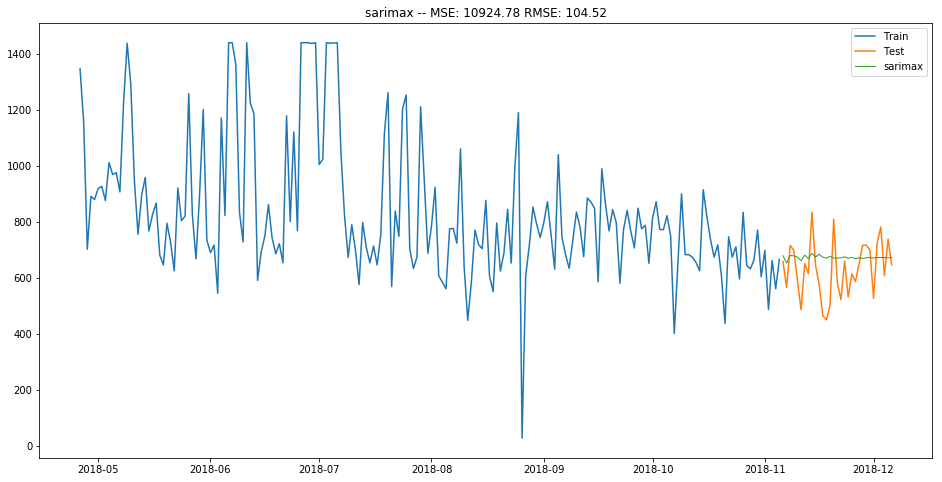

In [95]:
plot_and_eval(yhat.sarimax, linewidth=1)

In [120]:
no_outliers = fitbit[fitbit.steps > 1000]

no_outliers.loc[no_outliers.hours_awake == 24, 'minutes_sedentary'] = no_outliers.minutes_sedentary.mean()

no_outliers['total_minutes'] = no_outliers.minutes_sedentary + no_outliers.minutes_fairly_active +\
                          no_outliers.minutes_lightly_active + no_outliers.minutes_very_active

no_outliers['hours_awake'] = no_outliers.total_minutes/60
no_outliers['hours_asleep'] = 24 - no_outliers.hours_awake

In [121]:
no_outliers.describe()

calories_burned         steps    distance      floors  \
count       205.000000    205.000000  205.000000  205.000000   
mean       3524.278049   9351.843902    4.433512   13.804878   
std         508.676161   4774.923210    2.281289   26.771930   
min        2465.000000   1187.000000    0.560000    0.000000   
25%        3149.000000   5879.000000    2.770000    4.000000   
50%        3444.000000   8316.000000    3.920000    7.000000   
75%        3801.000000  13257.000000    6.290000   14.000000   
max        5199.000000  25512.000000   12.000000  195.000000   

       minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
count         205.000000              205.000000             205.000000   
mean          768.531707              205.385366              16.375610   
std           184.772874               53.207444              15.337075   
min           402.000000               46.000000               0.000000   
25%           651.000000              170.000000               5.000000   
50%           735.000000              209.000000              13.000000   
75%           839.000000              239.000000              22.000000   
max          1361.000000              349.000000              78.000000   

       minutes_very_active  activity_calories     calories     fat (g)  \
count            205.00000         205.000000   205.000000  205.000000   
mean              37.17561        1623.468293    61.604878    2.497561   
std               37.35952         628.363830   329.384222   12.859964   
min                0.00000         389.000000     0.000000    0.000000   
25%                6.00000        1172.000000     0.000000    0.000000   
50%               22.00000        1530.000000     0.000000    0.000000   
75%               69.00000        2027.000000     0.000000    0.000000   
max              154.00000        3596.000000  2276.000000   83.000000   

        fiber (g)   carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
count  205.000000  205.000000   205.000000   205.000000          205.0   
mean     0.585366    6.717073   153.043902     2.819512            0.0   
std      4.158476   37.626622   842.338786    15.050621            0.0   
min      0.000000    0.000000     0.000000     0.000000            0.0   
25%      0.000000    0.000000     0.000000     0.000000            0.0   
50%      0.000000    0.000000     0.000000     0.000000            0.0   
75%      0.000000    0.000000     0.000000     0.000000            0.0   
max     52.000000  291.000000  6550.000000    99.000000            0.0   

       total_minutes          bmr  hours_awake  hours_asleep  
count     205.000000   205.000000   205.000000    205.000000  
mean     1027.468293  1900.809756    17.124472      6.875528  
std       153.374319   167.825563     2.556239      2.556239  
min       749.000000  1455.000000    12.483333      0.000000  
25%       936.000000  1786.000000    15.600000      6.216667  
50%       987.000000  1903.000000    16.450000      7.550000  
75%      1067.000000  2012.000000    17.783333      8.400000  
max      1440.000000  2291.000000    24.000000     11.516667

In [117]:
pd.cut(fitbit.reset_index().steps, 10).value_counts()

(5102.4, 7653.6]      52
(7653.6, 10204.8]     37
(2551.2, 5102.4]      30
(-25.512, 2551.2]     29
(10204.8, 12756.0]    24
(15307.2, 17858.4]    23
(12756.0, 15307.2]    23
(17858.4, 20409.6]     5
(22960.8, 25512.0]     1
(20409.6, 22960.8]     1
Name: steps, dtype: int64

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([29., 30., 52., 37., 24., 23., 23.,  5.,  1.,  1.]),
 array([    0. ,  2551.2,  5102.4,  7653.6, 10204.8, 12756. , 15307.2,
        17858.4, 20409.6, 22960.8, 25512. ]),
 <a list of 10 Patch objects>)

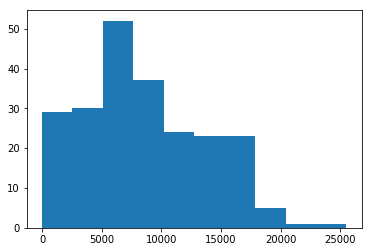

In [110]:
plt.hist(fitbit.reset_index().steps)

(array([19., 36., 51., 27., 20., 26., 18.,  5.,  2.,  1.]),
 array([ 0.56 ,  1.704,  2.848,  3.992,  5.136,  6.28 ,  7.424,  8.568,
         9.712, 10.856, 12.   ]),
 <a list of 10 Patch objects>)

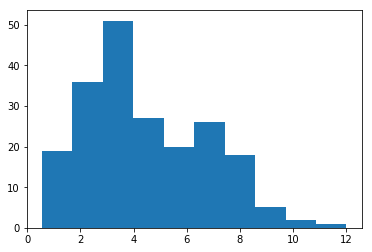

In [124]:
plt.hist(no_outliers.reset_index().distance)

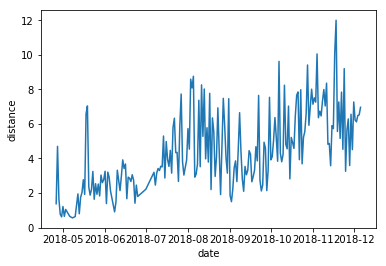

In [125]:
sns.lineplot(x=no_outliers.reset_index().date, y=no_outliers.reset_index().distance)

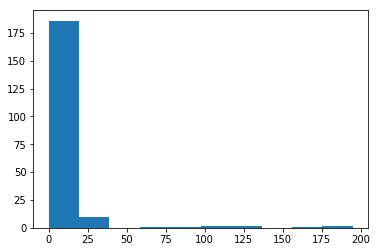

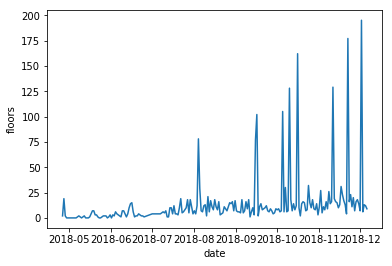

In [126]:
plt.hist(no_outliers.reset_index().floors)
plt.show()


sns.lineplot(x=no_outliers.reset_index().date, y=no_outliers.reset_index().floors)
plt.show()

In [127]:
columns

Index(['steps', 'distance', 'floors', 'minutes_sedentary',
       'minutes_lightly_active', 'minutes_fairly_active',
       'minutes_very_active', 'activity_calories'],
      dtype='object')

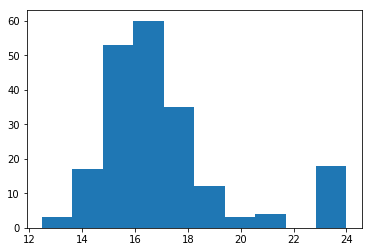

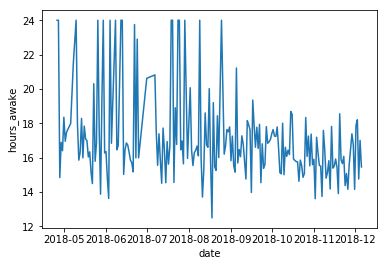

In [129]:
plt.hist(no_outliers.reset_index().hours_awake)
plt.show()


sns.lineplot(x=no_outliers.reset_index().date, y=no_outliers.reset_index().hours_awake)
plt.show()

In [137]:
fitbit[fitbit.minutes_sedentary == 1440]

calories_burned  steps  distance  floors  minutes_sedentary  \
date                                                                      
2018-06-06           2145.0    0.0       0.0     0.0             1440.0   
2018-06-07           2146.0    0.0       0.0     0.0             1440.0   
2018-06-11           2146.0    0.0       0.0     0.0             1440.0   
2018-06-26           2144.0    0.0       0.0     0.0             1440.0   
2018-06-27           2145.0    0.0       0.0     0.0             1440.0   
2018-06-28           2145.0    0.0       0.0     0.0             1440.0   
2018-06-30           2145.0    0.0       0.0     0.0             1440.0   
2018-07-03           2144.0    0.0       0.0     0.0             1440.0   
2018-07-06           2144.0    0.0       0.0     0.0             1440.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-06-06                     0.0                    0.0   
2018-06-07                     0.0                    0.0   
2018-06-11                     0.0                    0.0   
2018-06-26                     0.0                    0.0   
2018-06-27                     0.0                    0.0   
2018-06-28                     0.0                    0.0   
2018-06-30                     0.0                    0.0   
2018-07-03                     0.0                    0.0   
2018-07-06                     0.0                    0.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-06-06                  0.0                0.0       0.0      ...        
2018-06-07                  0.0                0.0       0.0      ...        
2018-06-11                  0.0                0.0       0.0      ...        
2018-06-26                  0.0                0.0       0.0      ...        
2018-06-27                  0.0                0.0       0.0      ...        
2018-06-28                  0.0                0.0       0.0      ...        
2018-06-30                  0.0                0.0       0.0      ...        
2018-07-03                  0.0                0.0       0.0      ...        
2018-07-06                  0.0                0.0       0.0      ...        

            carbs (g)  sodium (mg)  protein (g)  water (fl oz)  total_minutes  \
date                                                                            
2018-06-06        0.0          0.0          0.0            0.0         1440.0   
2018-06-07        0.0          0.0          0.0            0.0         1440.0   
2018-06-11        0.0          0.0          0.0            0.0         1440.0   
2018-06-26        0.0          0.0          0.0            0.0         1440.0   
2018-06-27        0.0          0.0          0.0            0.0         1440.0   
2018-06-28        0.0          0.0          0.0            0.0         1440.0   
2018-06-30        0.0          0.0          0.0            0.0         1440.0   
2018-07-03        0.0          0.0          0.0            0.0         1440.0   
2018-07-06        0.0          0.0          0.0            0.0         1440.0   

            day_of_week  weekend_or_weekday     bmr hours_awake  hours_asleep  
date                                                                           
2018-06-06    Wednesday             weekday  2145.0        24.0           0.0  
2018-06-07     Thursday             weekday  2146.0        24.0           0.0  
2018-06-11       Monday             weekday  2146.0        24.0           0.0  
2018-06-26      Tuesday             weekday  2144.0        24.0           0.0  
2018-06-27    Wednesday             weekday  2145.0        24.0           0.0  
2018-06-28     Thursday             weekday  2145.0        24.0           0.0  
2018-06-30     Saturday             weekend  2145.0        24.0           0.0  
2018-07-03      Tuesday             weekday

In [139]:
no_outliers.loc[no_outliers.hours_awake == 24, 'minutes_sedentary'] = no_outliers.minutes_sedentary.mean()
no_outliers[no_outliers.hours_awake == 24].head()

no_outliers['total_minutes'] = no_outliers.minutes_sedentary + no_outliers.minutes_fairly_active +\
                          no_outliers.minutes_lightly_active + no_outliers.minutes_very_active

no_outliers['hours_awake'] = no_outliers.total_minutes/60
no_outliers['hours_asleep'] = 24 - no_outliers.hours_awake

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-04-26           2635.0   2931.0      1.38     2.0         768.531707   
2018-04-27           3649.0   9971.0      4.70    19.0         768.531707   
2018-05-10           3081.0   1364.0      0.64     0.0         768.531707   
2018-05-26           3121.0   4092.0      1.93     2.0         768.531707   
2018-05-30           3324.0   5519.0      2.60     1.0         768.531707   
2018-06-04           3585.0   6162.0      2.91     6.0         768.531707   
2018-06-08           2465.0   1929.0      0.91     1.0         768.531707   
2018-06-12           3352.0   4535.0      2.14     1.0         768.531707   
2018-06-13           3335.0   6344.0      2.99     4.0         768.531707   
2018-07-19           3993.0   9484.0      4.47     4.0         768.531707   
2018-07-20           3110.0   6680.0      3.15     3.0         768.531707   
2018-07-24           3510.0   9215.0      4.35     6.0         768.531707   
2018-07-25           3069.0   5666.0      2.67     8.0         768.531707   
2018-07-29           3316.0   6450.0      3.04    18.0         768.531707   
2018-08-09           4339.0  15635.0      7.37    13.0         768.531707   
2018-08-25           3719.0   4054.0      1.91     7.0         768.531707   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-05-10                   136.0                    5.0   
2018-05-26                   172.0                    7.0   
2018-05-30                   217.0                   19.0   
2018-06-04                   225.0                   36.0   
2018-06-08                    79.0                    0.0   
2018-06-12                   186.0                   20.0   
2018-06-13                   241.0                    5.0   
2018-07-19                   243.0                   57.0   
2018-07-20                   136.0                   28.0   
2018-07-24                   193.0                   15.0   
2018-07-25                   176.0                    4.0   
2018-07-29                   192.0                   17.0   
2018-08-09                   285.0                   17.0   
2018-08-25                   204.0                   23.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-04-26                  0.0              566.0       0.0      ...        
2018-04-27                 17.0             1752.0       0.0      ...        
2018-05-10                  4.0              924.0       0.0      ...        
2018-05-26                  3.0              999.0       0.0      ...        
2018-05-30                  3.0             1264.0       0.0      ...        
2018-06-04                  8.0             1530.0       0.0      ...        
2018-06-08                  0.0              389.0       0.0      ...        
2018-06-12                 10.0             1241.0       0.0      ...        
2018-06-13                  8.0             1333.0       0.0      ...        
2018-07-19                 24.0             2093.0       0.0      ...        
2018-07-20                 14.0             1172.0       0.0      ...        
2018-07-24                 29.0             1551.0       0.0      ...        
2018-07-25                  7.0             1062.0       0.0      ...        
2018-07-29                 20.0             1382.0       0.0      ...        
2018-08-09                 77.0             2566.0       0.0      ...        
2018-08-25                 23.0             1731.0       0.0      ...        

            carbs (g)  sodium (mg)  protein (g)  water (fl oz)  total_minutes  \
date                                    

In [146]:
no_outliers['total_minutes'] = no_outliers.minutes_sedentary + no_outliers.minutes_fairly_active +\
                          no_outliers.minutes_lightly_active + no_outliers.minutes_very_active

no_outliers['hours_awake'] = no_outliers.total_minutes/60
no_outliers['hours_asleep'] = 24 - no_outliers.hours_awake

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

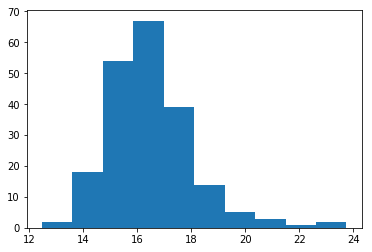

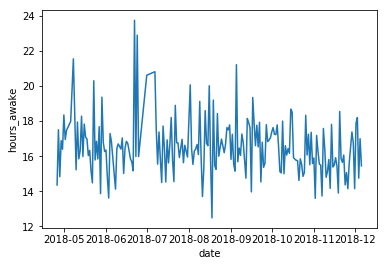

In [147]:
plt.hist(no_outliers.reset_index().hours_awake)
plt.show()


sns.lineplot(x=no_outliers.reset_index().date, y=no_outliers.reset_index().hours_awake)
plt.show()

In [149]:
no_outliers[no_outliers.hours_awake > 20]

calories_burned   steps  distance  floors  minutes_sedentary  \
date                                                                       
2018-05-08           2591.0  1187.0      0.56     2.0             1221.0   
2018-05-23           3772.0  6889.0      3.25     0.0              921.0   
2018-06-22           3290.0  5805.0      2.74     3.0             1179.0   
2018-06-24           3355.0  5209.0      2.46     2.0             1121.0   
2018-07-01           3090.0  4714.0      2.22     4.0             1005.0   
2018-07-07           3275.0  6775.0      3.20     4.0             1050.0   
2018-08-02           3968.0  9629.0      4.54     4.0              924.0   
2018-08-16           3490.0  8039.0      3.79    18.0              877.0   
2018-09-05           3395.0  7943.0      3.86    18.0             1040.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-05-08                    53.0                   17.0   
2018-05-23                   241.0                   42.0   
2018-06-22                   235.0                    2.0   
2018-06-24                   243.0                    0.0   
2018-07-01                   232.0                    0.0   
2018-07-07                   133.0                   52.0   
2018-08-02                   186.0                   43.0   
2018-08-16                   311.0                    7.0   
2018-09-05                   184.0                   16.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-05-08                  2.0              410.0       0.0      ...        
2018-05-23                 14.0             1765.0       0.0      ...        
2018-06-22                  9.0             1278.0       0.0      ...        
2018-06-24                 10.0             1450.0       0.0      ...        
2018-07-01                  0.0             1125.0       0.0      ...        
2018-07-07                 14.0             1289.0       0.0      ...        
2018-08-02                 51.0             2008.0       0.0      ...        
2018-08-16                  6.0             1678.0       0.0      ...        
2018-09-05                 33.0             1514.0       0.0      ...        

            carbs (g)  sodium (mg)  protein (g)  water (fl oz)  total_minutes  \
date                                                                            
2018-05-08        0.0          0.0          0.0            0.0         1293.0   
2018-05-23        0.0          0.0          0.0            0.0         1218.0   
2018-06-22        0.0          0.0          0.0            0.0         1425.0   
2018-06-24        0.0          0.0          0.0            0.0         1374.0   
2018-07-01        0.0          0.0          0.0            0.0         1237.0   
2018-07-07        0.0          0.0          0.0            0.0         1249.0   
2018-08-02        0.0          0.0          0.0            0.0         1204.0   
2018-08-16        0.0          0.0          0.0            0.0         1201.0   
2018-09-05        0.0          0.0          0.0            0.0         1273.0   

            day_of_week  weekend_or_weekday     bmr hours_awake  hours_asleep  
date                                                                           
2018-05-08          NaN                 NaN  2181.0   21.550000      2.450000  
2018-05-23          NaN                 NaN  2007.0   20.300000      3.700000  
2018-06-22          NaN                 NaN  2012.0   23.750000      0.250000  
2018-06-24          NaN                 NaN  1905.0   22.900000      1.100000  
2018-07-01          NaN                 NaN  1965.0   20.616667      3.383333  
2018-07-07          NaN                 NaN  1986.0   20.816667      3.183333  
2018-08-02          NaN                 NaN  1960.0   20.066667      3.933333  
2018-08-16          NaN         

In [150]:
no_outliers.sample(10)

calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-12-01           3813.0  14510.0      7.27     7.0         527.000000   
2018-12-05           3670.0  13865.0      6.52    12.0         739.000000   
2018-07-25           3069.0   5666.0      2.67     8.0         768.531707   
2018-08-06           3150.0   6185.0      2.92     7.0         775.000000   
2018-11-21           3738.0  11079.0      5.16     4.0         582.000000   
2018-05-16           3497.0   5882.0      2.77     1.0         825.000000   
2018-09-20           3517.0   9920.0      4.68     8.0         844.000000   
2018-08-23           4232.0  14696.0      6.93    11.0         653.000000   
2018-10-12           3427.0  10203.0      4.81     7.0         674.000000   
2018-11-28           3088.0   7602.0      3.59    16.0         717.000000   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-12-01                   233.0                   22.0   
2018-12-05                   200.0                   12.0   
2018-07-25                   176.0                    4.0   
2018-08-06                   210.0                    0.0   
2018-11-21                   328.0                    9.0   
2018-05-16                   234.0                    5.0   
2018-09-20                   156.0                   10.0   
2018-08-23                   210.0                   18.0   
2018-10-12                   259.0                   20.0   
2018-11-28                   272.0                    0.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-12-01                 67.0             2124.0       0.0      ...        
2018-12-05                 69.0             1968.0       0.0      ...        
2018-07-25                  7.0             1062.0       0.0      ...        
2018-08-06                  0.0             1121.0       0.0      ...        
2018-11-21                 33.0             2101.0       0.0      ...        
2018-05-16                  6.0             1396.0       0.0      ...        
2018-09-20                 56.0             1565.0       0.0      ...        
2018-08-23                 79.0             2261.0       0.0      ...        
2018-10-12                 11.0             1630.0       0.0      ...        
2018-11-28                  0.0             1361.0       0.0      ...        

            carbs (g)  sodium (mg)  protein (g)  water (fl oz)  total_minutes  \
date                                                                            
2018-12-01        0.0          0.0          0.0            0.0     849.000000   
2018-12-05        0.0          0.0          0.0            0.0    1020.000000   
2018-07-25        0.0          0.0          0.0            0.0     955.531707   
2018-08-06        0.0          0.0          0.0            0.0     985.000000   
2018-11-21        0.0          0.0          0.0            0.0     952.000000   
2018-05-16        0.0          0.0          0.0            0.0    1070.000000   
2018-09-20        0.0          0.0          0.0            0.0    1066.000000   
2018-08-23        0.0          0.0          0.0            0.0     960.000000   
2018-10-12        0.0          0.0          0.0            0.0     964.000000   
2018-11-28        0.0          0.0          0.0            0.0     989.000000   

            day_of_week  weekend_or_weekday     bmr hours_awake  hours_asleep  
date                                                                           
2018-12-01          NaN                 NaN  1689.0   14.150000      9.850000  
2018-12-05          NaN                 NaN  1702.0   17.000000      7.000000  
2018-07-25          NaN                 NaN  2007.0   15.925528      8.074472  
2018-08-06          NaN                 NaN 

In [155]:
no_outliers.shape

(205, 22)

In [158]:
train = no_outliers.steps[:174]
test = no_outliers.steps[174:]

print(train.shape)
print(test.shape)

(174,)
(31,)


date  calories_burned    steps  distance  floors  minutes_sedentary  \
0   2018-04-26           2635.0   2931.0      1.38     2.0         768.531707   
1   2018-04-27           3649.0   9971.0      4.70    19.0         768.531707   
2   2018-04-28           3379.0   3521.0      1.66     2.0         702.000000   
3   2018-04-29           2851.0   1639.0      0.77     0.0         891.000000   
4   2018-04-30           2825.0   1323.0      0.62     0.0         880.000000   
5   2018-05-01           3292.0   2581.0      1.22     0.0         919.000000   
6   2018-05-02           2660.0   1372.0      0.65     0.0         927.000000   
7   2018-05-03           3121.0   2232.0      1.05     0.0         876.000000   
8   2018-05-06           2771.0   1383.0      0.65     0.0         976.000000   
9   2018-05-08           2591.0   1187.0      0.56     2.0        1221.000000   
10  2018-05-10           3081.0   1364.0      0.64     0.0         768.531707   
11  2018-05-11           2950.0   2771.0      1.31     1.0         947.000000   
12  2018-05-12           3318.0   4125.0      1.95     2.0         756.000000   
13  2018-05-13           2572.0   1689.0      0.80     0.0         895.000000   
14  2018-05-14           2966.0   3710.0      1.75     0.0         959.000000   
15  2018-05-15           3152.0   4313.0      2.03     0.0         767.000000   
16  2018-05-16           3497.0   5882.0      2.77     1.0         825.000000   
17  2018-05-17           3066.0   4080.0      1.92     4.0         867.000000   
18  2018-05-18           4376.0  13958.0      6.58     7.0         682.000000   
19  2018-05-19           4112.0  14917.0      7.04     7.0         646.000000   
20  2018-05-20           3098.0   4986.0      2.35     3.0         795.000000   
21  2018-05-21           3009.0   3989.0      1.88     3.0         727.000000   
22  2018-05-22           3581.0   4680.0      2.21     1.0         625.000000   
23  2018-05-23           3772.0   6889.0      3.25     0.0         921.000000   
24  2018-05-24           2756.0   3470.0      1.64     0.0         804.000000   
25  2018-05-25           3155.0   5389.0      2.54     1.0         821.000000   
26  2018-05-26           3121.0   4092.0      1.93     2.0         768.531707   
27  2018-05-27           3407.0   5347.0      2.52     2.0         825.000000   
28  2018-05-28           3213.0   3875.0      1.83     2.0         668.000000   
29  2018-05-29           3466.0   6448.0      3.04     0.0         899.000000   
..         ...              ...      ...       ...     ...                ...   
175 2018-11-07           3681.0  13664.0      6.46     9.0         566.000000   
176 2018-11-08           4137.0  15542.0      7.33    26.0         716.000000   
177 2018-11-09           4445.0  16732.0      7.99    14.0         698.000000   
178 2018-11-10           3863.0  13636.0      7.04    16.0         589.000000   
179 2018-11-11           4264.0  17761.0      8.36   129.0         486.000000   
180 2018-11-12           3444.0  10184.0      4.82    19.0         651.000000   
181 2018-11-13           3202.0  10330.0      4.87    16.0         615.000000   
182 2018-11-14           3081.0   7598.0      3.58    15.0         835.000000   
183 2018-11-15           3815.0  12360.0      5.90    10.0         644.000000   
184 2018-11-16           3780.0  12286.0      5.73    13.0         576.000000   
185 2018-11-17           4548.0  20395.0     10.06    31.0         464.000000   
186 2018-11-18           4832.0  25512.0     12.00    23.0         450.000000   
187 2018-11-19           3697.0  11993.0      5.56    17.0         502.000000   
188 2018-11-20           3966.0  15527.0      7.27    13.0         810.000000   
189 2018-11-21           3738.0  11079.0      5.16     4.0         582.000000   
190 2018-11-22           4494.0  16705.0      7.84   177.0         522.000000   
191 2018-11-23           3325.0   9602.0      4.53    16.0         660.000000   
192 2018-11-24           4098.0  17004.0 

Performing TSA for steps.


Train/Test plot


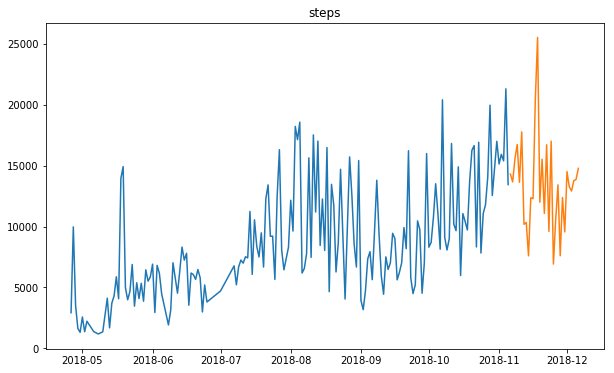



Simple Average


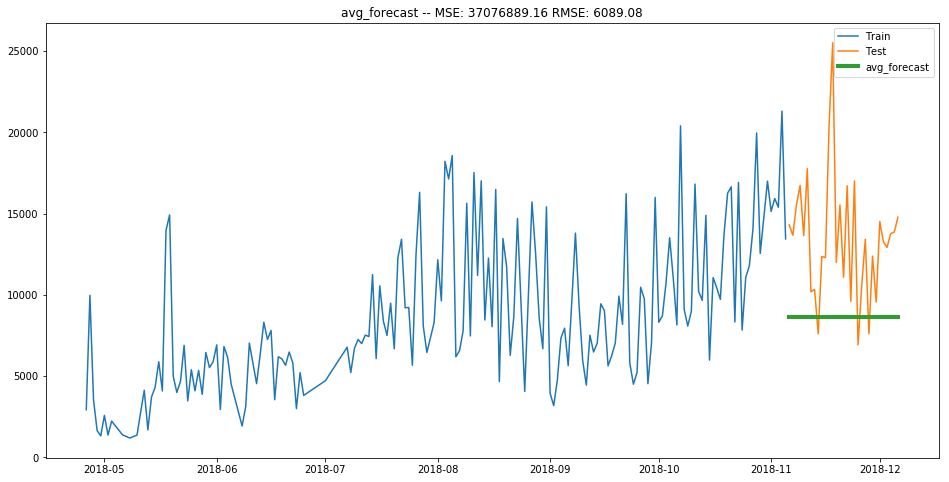



Rolling Average


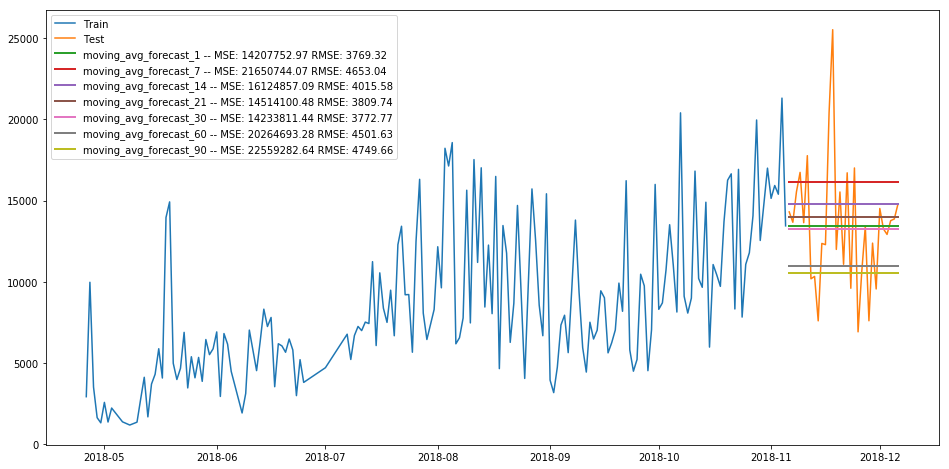



Predicting based off last 31 days


ValueError: Length mismatch: Expected axis has 11 elements, new values have 31 elements

In [163]:
for col in columns:
    print(f'Performing TSA for {col}.')
    train = no_outliers.steps[:174]
    test = no_outliers.steps[174:]
    data_to_predict = fitbit[col][225:]

    print('\n')
    print(f'Train/Test plot')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train)
    plt.plot(test)
    plt.title(col)
    plt.show()
    
    yhat = pd.DataFrame(dict(actual=test))
    yhat['avg_forecast'] = train.mean()
    yhat.head()
    
    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
            mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
            if len(predictions) > 1:
                label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

        if len(predictions) == 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()    
    
    print('\n')
    print(f'Simple Average')
    plot_and_eval(yhat.avg_forecast)
    
    print('\n')
    print(f'Rolling Average')
    
    period_vals = [1, 7, 14, 21, 30, 60, 90]

    for periods in period_vals:
        yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

    forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

    plot_and_eval(forecasts, linewidth=2)
    
#     print('\n')
#     print(f'Holt Linear Trend')
    
#     sm.tsa.seasonal_decompose(train).plot()
#     result = sm.tsa.stattools.adfuller(train)
#     plt.show()
    
#     holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

#     yhat['holt_linear'] = holt.forecast(test.shape[0])
    
#     plot_and_eval(yhat.holt_linear)
    
    print('\n')
    print(f'Predicting based off last 31 days')
    
    using_last_year = train[163:194].reset_index().drop(columns='date').set_index(test.index)

    yhat['last_31_days'] = using_last_year
    plot_and_eval(yhat.last_31_days, linewidth=1)